In [56]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.dynamics.single_track import SingleTrack
from pit.parameters import NormalParameterGroup, CovariantNormalParameterGroup, PointParameterGroup
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DEVICE = "cpu"
print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# # visualization
# with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
#     data = json.load(f)

with open('synced_data.json', 'r') as f:
     data = json.load(f)

cpu


In [57]:
# %%
timestep = 0.03
# assert(data['time'][1] - data['time'][0] - timestep < 0.001)
FIRST = 300
LAST = 10
x = torch.tensor(data['x'][FIRST:-LAST])
y = torch.tensor(data['y'][FIRST:-LAST])
yaw = torch.tensor(data['yaw'][FIRST:-LAST])
vx = torch.tensor(data['vx'][FIRST:-LAST])
vy = torch.tensor(data['vy'][FIRST:-LAST])
yaw_rate = torch.tensor(data['yaw_rate'][FIRST:-LAST])
steer_angle = torch.tensor(data['steer_angle'][FIRST:-LAST])
# drive_force = torch.tensor(data['drive_force'])
# steer_speed = torch.tensor(data['steer_speed'])
# time = torch.tensor(data['time'])
# FIRST = 100
# LAST = 1000
# x = torch.tensor(data['x'][FIRST:-LAST])
# y = torch.tensor(data['y'][FIRST:-LAST])
# yaw = torch.tensor(data['yaw'][FIRST:-LAST])
# yaw_rate = torch.tensor(data['yaw_rate'][FIRST:-LAST])
# steer_angle = torch.tensor(data['steer_angle'][FIRST:-LAST])
accel = torch.tensor(data['linear_acceleration_x'][FIRST:-LAST])
accel = -1 * accel
# delta_times = torch.tensor(data['dt'][FIRST:-LAST])
# time = torch.tensor(data['time'])#[FIRST:-LAST])
try:
    delta_times = torch.tensor(data['dt'])
except KeyError:
    delta_times = time[1:] - time[:-1]
delta_times = delta_times[FIRST:-LAST]
# vx = torch.tensor(data['vx'][FIRST:-LAST])
# vy = torch.tensor(data['vy'][FIRST:-LAST])

# vy = -1 * vy
# vx = -1 * vx
# drive_force = accel * 15.2
#Get the velocity array from vx and vy
v = torch.norm(torch.stack([vx, vy], dim=0), dim=0)
#get accel by taking the derivative of velocity over time dv/dt
# accel = torch.zeros_like(v)
# accel[1:] = (v[1:] - v[:-1]) / (time[1:] - time[:-1])

# accel = 
#Get the slip angle array from vx and vy
slip_angle = torch.atan2(vy, vx)
# slip_angle = -1 * slip_angle

#get accel from dv /dt
# accel = torch.zeros_like(v)
accel = torch.diff(v) / delta_times[1:]


# Trim the last element of the arrays to make them the same length
x = x[:-1]
y = y[:-1]
yaw = yaw[:-1]
yaw_rate = yaw_rate[:-1]
steer_angle = steer_angle[:-1]
v = v[:-1]
slip_angle = slip_angle[:-1]
delta_times = delta_times[1:]


In [58]:
# steer_speed = (steer_angle[1:] - steer_angle[:-1]) / delta_times[:-1]
# 

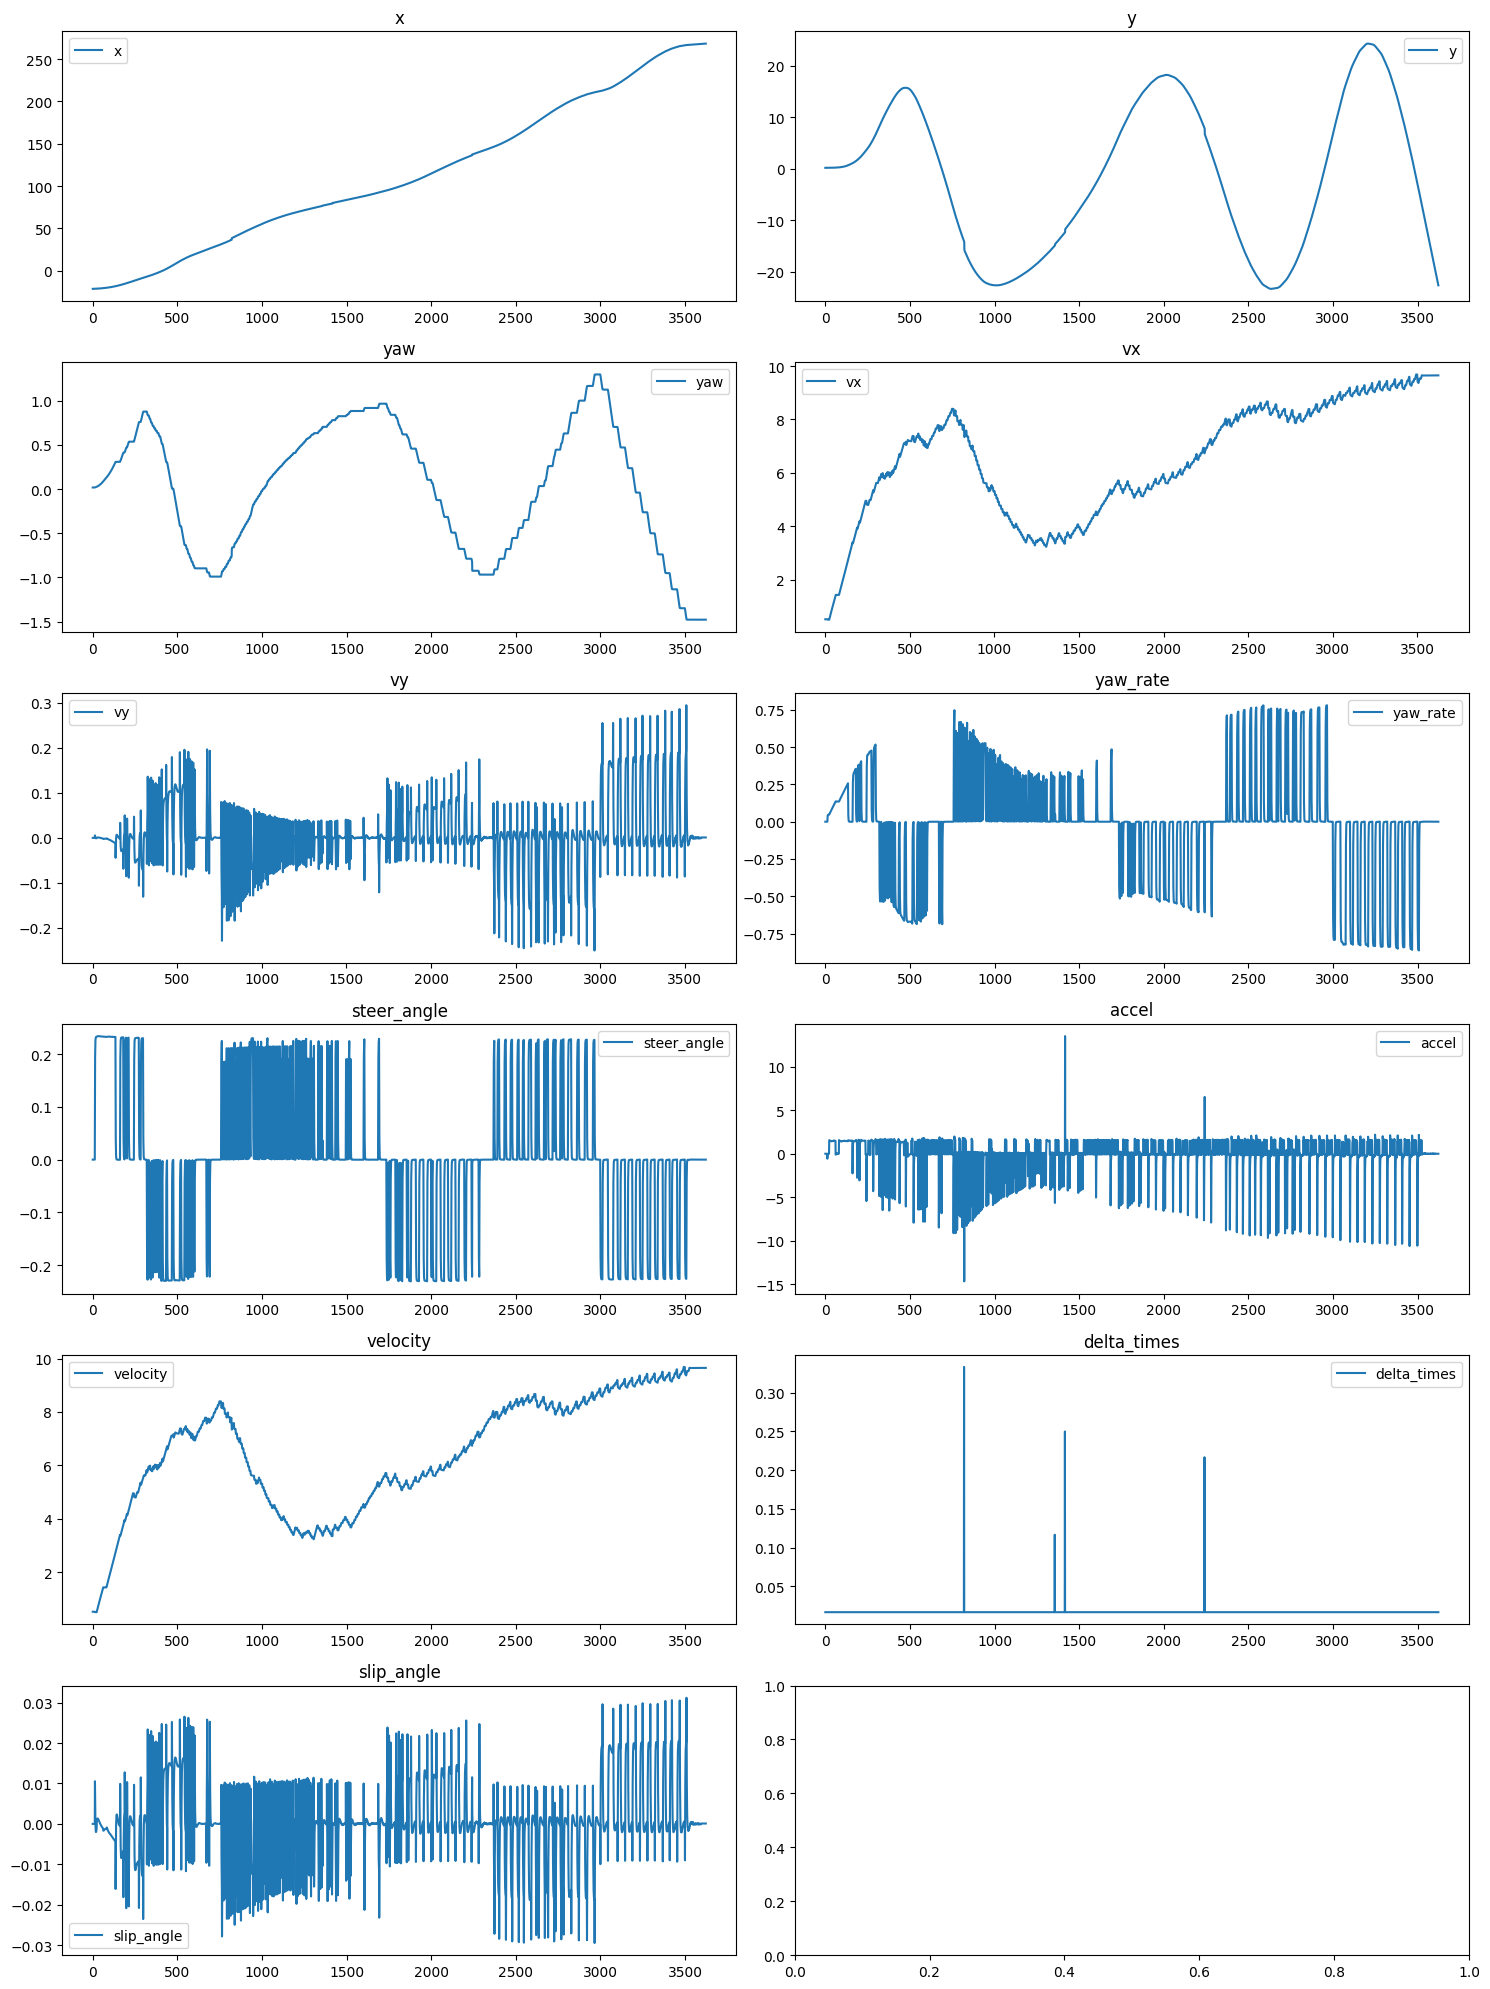

In [59]:
# Plot each tensor
fig, axs = plt.subplots(6, 2, figsize=(15, 20))

# Plot x and y
axs[0, 0].plot(x.numpy(), label='x')
axs[0, 0].set_title('x')
axs[0, 0].legend()

axs[0, 1].plot(y.numpy(), label='y')
axs[0, 1].set_title('y')
axs[0, 1].legend()

# Plot yaw and vx
axs[1, 0].plot(yaw.numpy(), label='yaw')
axs[1, 0].set_title('yaw')
axs[1, 0].legend()

axs[1, 1].plot(vx.numpy(), label='vx')
axs[1, 1].set_title('vx')
axs[1, 1].legend()

# Plot vy and yaw_rate
axs[2, 0].plot(vy.numpy(), label='vy')
axs[2, 0].set_title('vy')
axs[2, 0].legend()

axs[2, 1].plot(yaw_rate.numpy(), label='yaw_rate')
axs[2, 1].set_title('yaw_rate')
axs[2, 1].legend()

# Plot steer_angle and accel
axs[3, 0].plot(steer_angle.numpy(), label='steer_angle')
axs[3, 0].set_title('steer_angle')
axs[3, 0].legend()

axs[3, 1].plot(accel.numpy(), label='accel')
axs[3, 1].set_title('accel')
axs[3, 1].legend()

# # Plot steer_speed and delta_times
axs[4, 0].plot(v.numpy(), label='velocity')
axs[4, 0].set_title('velocity')
axs[4, 0].legend()

axs[4, 1].plot(delta_times.numpy(), label='delta_times')
axs[4, 1].set_title('delta_times')
axs[4, 1].legend()
# axs[4, 1].set_yscal

axs[5, 0].plot(slip_angle.numpy(), label='slip_angle')
axs[5, 0].set_title('slip_angle')
axs[5, 0].legend()

# axs[5, 1].plot(untranslated_vy.numpy(), label='untranslated_vy')
# axs[5, 1].set_title('untranslated_vy')
# axs[5, 1].legend()

# Show the plots
plt.tight_layout()
plt.show()

In [60]:
# yaw.max()
# drive_force = accel * 15.2
# drive_force = drive_force[:-1]
# steer_speed = (steer_angle[1:] - steer_angle[:-1]) / delta_times[:-1]

In [61]:
# # state = [X Y V YAW YAW_RATE SLIP_ANGLE]
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)

initial_state = torch.tensor([x[0],y[0],v[0],yaw[0],yaw_rate[0],slip_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([steer_angle, accel]).T
# control_inputs = torch.vstack([drive_force, steer_speed]).T
# control_inputs = control_inputs.contiguous().to(DEVICE)
# output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
output_states = torch.vstack([x, y, v, yaw, yaw_rate, slip_angle]).T
target_states = output_states#[1:]
target_states = target_states.contiguous().to(DEVICE)


print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([3624, 2]) | States size: torch.Size([3624, 6])


In [62]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=10
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)
batched_delta_time = torch.zeros((total_steps, TICKS_IN_STEP), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*  STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]
    batched_delta_time[step] = delta_times[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([361, 10, 2]) | Batched States size: torch.Size([361, 10, 6])


In [63]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states, batched_delta_time)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [64]:
# %%

# san_paulo_single_track_params = {
#     'l': 0.8,
#     'w': 0.55,
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'm': 1225.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'hcg': 0.0,  # [rad/m]  DF
#     'Csf': 1.3507,
#     'mu' : 1.1,
#     'Csr': 1.3507,

# }

# params = {
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 1225.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 1.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 1.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }


# params_cinnamon = {
#     # axes distances
#     'lf': 0.2725,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 0.2585,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 0.6433215993,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 15.32,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 1.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 1.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }

# single_track_params = {
#     # Length and width of the vehicle
#     'l': 0.8,
#     'w': 0.55, 

    
#     # moments of inertia of sprung mass
#     # masses
#     'm': 15.32,  # vehicle mass [kg]  MASS
#     'Iz': 0.64332,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    
#     # axes distancelinear_acceleration_x # height of the center of gravity [m]  HCG

#     # tire cornering stiffness
#     'Csf': 0.03,  # front tire cornering stiffness [N/rad]  CF
#     'Csr': 0.03,  # rear tire cornering stiffness [N/rad]  CR

#     # tire friction coefficient
#     'mu': 0.7,  # tire friction coefficient  MU

# }

awsim_params = {
    # Length and width of the vehicle
    'l': 2.5,
    'w': 1.8, 

    
    # moments of inertia of sprung mass
    # masses
    'm': 1500.0,  # vehicle mass [kg]  MASS
    'Iz': 2000.0,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    
    # axes distances
    'lf': 0.75,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.75,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # height of the center of gravity
    'hcg': 0.1825,  # height of the center of gravity [m]  HCG

    # tire cornering stiffness
    'Csf': 20.03,  # front tire cornering stiffness [N/rad]  CF
    'Csr': 20.03,  # rear tire cornering stiffness [N/rad]  CR

    # tire friction coefficient
    'mu': 0.7,  # tire friction coefficient  MU

}

# awsim_params.update(
# {
# 	"l" : 2.5,
# 	"w" : 1.7999999523162842,
# 	"m" : 1500.0,
# 	"Iz" : 2000.0,
# 	"lf" : 0.75,
# 	"lr" : 1.75,
# 	"hcg" : 0.1825,
# 	"Csf" : 20.00762367248535,
# 	"Csr" : 20.055543899536133,
# 	"mu" : 0.7855576872825623,
# }
# )

# )
"""
# awsim_dynamic_bycicle_params = {
#     #     # axes distances
#     'lf': 0.75,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.75,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 2000.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'mass': 1500.887,  # vehicle mass [kg]  MASS

#     # Pacejka tire force parameters
#     'Df': 3709.08227,  # [rad/m]  DF
#     'Cf': 20.3507,
#     'Bf': 16.2216,
#     'Dr': 3709.08227,  # [rad/m]  DR
#     'Cr': 20.3507,
#     'Br': 16.2216,
#     'Cm': 0.3777,
#     'Cr0': 2.1469,
#     'Cr2': 0.0,
# }
# awsim_dynamic_bycicle_params.update(
# {
# 	"lf" : 0.75,
# 	"lr" : 1.75,
# 	"Iz" : 2000.8533935546875,
# 	"mass" : 1500.886962890625,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 20.359413146972656,
# 	"Bf" : 16.22726058959961,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 20.352888107299805,
# 	"Br" : 16.220178604125977,
# 	"Cm" : 0.37744325399398804,
# 	"Cr0" : 2.146899938583374,
# 	"Cr2" : -0.00025437455042265356,
# })

# single_track_params = {
# 	"l" : 0.800000011920929,
# 	"w" : 0.550000011920929,
# 	"m" : 15.319999694824219,
# 	"Iz" : 0.6433200240135193,
# 	"lf" : 0.02734999917447567,
# 	"lr" : 0.025849999859929085,
# 	"hcg" : 0.1875,
# 	"Csf" : 5.042203903198242,
# 	"Csr" : 5.3044939041137695,
# 	"mu" : 0.03344631940126419,
# }

# san_paulo_single_track_params = {
#     'l': 0.8,
#     'w': 0.55,
#     # axes distances
#     'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
#     'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

#     # moments of inertia of sprung mass
#     # masses
#     'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
#     'm': 1225.887,  # vehicle mass [kg]  MASS

#     'hcg': 0.0,  # [rad/m]  DF
#     'Csf': 3.3564612865448,
#     'mu' : 1.1,
#     'Csr': 2.1139602661132812,

# }

# san_paulo_single_track_params.update(
# {
# 	"l" : 0.800000011920929,
# 	"w" : 0.550000011920929,
# 	"m" : 1225.886962890625,
# 	"Iz" : 1538.8533935546875,
# 	"lf" : 0.8839200139045715,
# 	"lr" : 1.5087599754333496,
# 	"hcg" : 0.0,
# 	"Csf" : 3.1625421047210693,
# 	"Csr" : 3.260910749435425,
# 	"mu" : 2.472494602203369,
# }
# )





# params.update({
# 	"lf" : 0.8839200139045715,
# 	"lr" : 1.5087599754333496,
# 	"Iz" : 1538.8533935546875,
# 	"mass" : 1225.886962890625,
# 	"Df" : 3709.082275390625,
# 	"Cf" : 2.6947877407073975,
# 	"Bf" : 16.383142471313477,
# 	"Dr" : 3709.082275390625,
# 	"Cr" : 1.7377768754959106,
# 	"Br" : 16.258201599121094,
# 	"Cm" : 0.95799320936203,
# 	"Cr0" : 2.147186756134033,
# 	"Cr2" : 0.001327928970567882,
# }
# )
# dynamics = DynamicBicycle(**awsim_dynamic_bycicle_params)
"""
dynamics = SingleTrack(**awsim_params)
param_group = PointParameterGroup(dynamics.parameter_list, awsim_params)

# Disable gradients for physical parameters
for param in ['l', 'w', 'lf', 'lr']:
#     param_group.disable_gradients(param)
# for param in ['lf', 'lr', 'Iz', 'mass']:
    param_group.disable_gradients(param)

for param in ['mu', 'Csf', 'Csr', 'Iz', 'm', 'hcg']:
#     param_group.enable_gradients(param)
# for param in ['Df', 'Cf', 'Bf', 'Dr', 'Cr', 'Br', 'Cm', 'Cr0', 'Cr2']:
    param_group.enable_gradients(param)
    
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
# dynamics.lf.requires_grad = False
# dynamics.lr.requires_grad = False
# dynamics.mass.requires_grad = False
# dynamics.Iz.requires_grad = False
# dynamics.Df.requires_grad = True
# dynamics.Cf.requires_grad = True
# dynamics.Bf.requires_grad = True
# dynamics.Dr.requires_grad = True
# dynamics.Cr.requires_grad = True
# dynamics.Br.requires_grad = True
# dynamics.Cm.requires_grad = True
# dynamics.Cr0.requires_grad = True
# dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, parameters=param_group, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, parameters=param_group, timestep=timestep)
rk4_integrator.to(DEVICE)

RK4(
  (dynamics): SingleTrack()
  (model_params): PointParameterGroup(
    (params): ParameterDict(
        (l): Parameter containing: [torch.FloatTensor of size ]
        (w): Parameter containing: [torch.FloatTensor of size ]
        (m): Parameter containing: [torch.FloatTensor of size ]
        (Iz): Parameter containing: [torch.FloatTensor of size ]
        (lf): Parameter containing: [torch.FloatTensor of size ]
        (lr): Parameter containing: [torch.FloatTensor of size ]
        (hcg): Parameter containing: [torch.FloatTensor of size ]
        (Csf): Parameter containing: [torch.FloatTensor of size ]
        (Csr): Parameter containing: [torch.FloatTensor of size ]
        (mu): Parameter containing: [torch.FloatTensor of size ]
    )
  )
)

In [65]:
#print out the shapes to inital state control input and delta times
# print(initial_state.shape)
# print(control_inputs.shape)
# print(delta_times.shape)
# control_inputs = control_inputs[1:]
# print(
# Ensure that the input tensors have compatible sizes
# assert control_inputs.shape[0] == delta_times.shape[0]

with torch.no_grad():
    rk4_output_states = rk4_integrator(initial_state, control_inputs, delta_times)
    # rk4_output_states = euler_integrator(initial_state, control_inputs)#, delta_times)


In [66]:
#print first five euer output states
# initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
print(rk4_output_states[10:20])

tensor([[-2.1397e+01,  1.8354e-01,  5.1666e-01,  1.7019e-02, -5.3554e-07,
         -1.4457e+00],
        [-2.1396e+01,  1.7501e-01,  5.1666e-01,  1.7019e-02,  1.9580e-06,
          4.9688e+00],
        [-2.1394e+01,  1.6672e-01,  5.0717e-01,  1.7019e-02, -9.0488e-02,
         -1.7078e+01],
        [-2.1396e+01,  1.7498e-01,  5.0346e-01,  1.5511e-02,  5.5666e-01,
          6.0555e+01],
        [-2.1401e+01,  1.6851e-01,  5.0216e-01,  2.4789e-02, -1.9111e+00,
         -2.1457e+02],
        [-2.1396e+01,  1.6187e-01,  5.0180e-01, -7.0628e-03,  7.0190e+00,
          7.6569e+02],
        [-2.1390e+01,  1.5551e-01,  5.0134e-01,  1.0992e-01, -2.5008e+01,
         -2.7317e+03],
        [-2.1391e+01,  1.6386e-01,  5.0134e-01, -3.0687e-01,  8.7750e+01,
          9.7604e+03],
        [-2.1396e+01,  1.6992e-01,  5.0112e-01,  1.1556e+00, -3.1111e+02,
         -3.4871e+04],
        [-2.1401e+01,  1.7706e-01,  5.0113e-01, -4.0295e+00,  1.0895e+03,
          1.2465e+05]])


In [67]:
rk4_output_states[:, 3].max()

tensor(5.0688e+11)

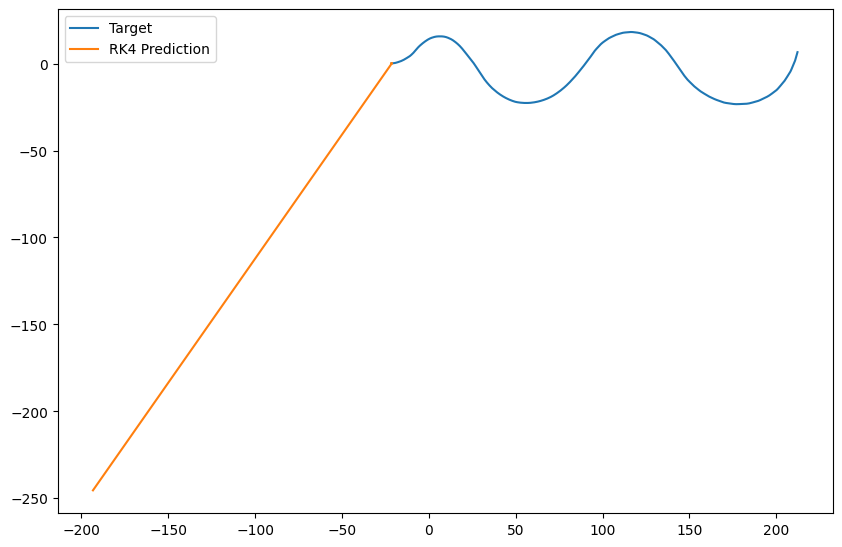

In [68]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=3000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
# ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [69]:
# %%
# from tqdm.auto import tqdm
# EPOCHS = 2000
# integrator = rk4_integrator
# optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3000, factor=0.9)

# # Define annealing parameters
# curriculum_steps = 200  # Number of steps before increasing the horizon
# eps_per_input = 20  # Epochs before increasing the horizon window
# step_size = 1  # How many extra steps to consider after each interval
# max_horizon = target_states.shape[1]  # Maximum horizon based on the data length
# initial_horizon = 10  # Initial number of steps to consider

# with torch.no_grad():
#         output_states = integrator(initial_state, control_inputs)
#         # Modulo the output states yaw to be between -pi and pi
#         output_states[:, 3] = (output_states[:, 3] + np.pi) % (2 * np.pi) - np.pi
        
#         val_loss = torch.nn.functional.l1_loss(output_states, target_states)
# print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

# losses = list()
# lrs = list()

# for epoch in tqdm(range(EPOCHS)):
#     for initial, inputs, targets, dts in dataloader:
#         # Determine the current step based on the epoch and curriculum
#         current_step = epoch // eps_per_input
#         current_horizon = min(initial_horizon + step_size * current_step, max_horizon)
        
#         integrator.train()
#         optimizer.zero_grad()
#         output_states = integrator(initial, inputs[:,:current_horizon], dts[:,:current_horizon])

#         # Check for NaNs in output_states
#         if torch.isnan(output_states).any():
#             print(f"NaN detected in output_states at Epoch: {epoch}. Breaking training loop.")
#             break

       
#         # Compute loss only for the current horizon
#         loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], targets[:, :current_horizon])


#         # Check for NaNs in loss
#         if torch.isnan(loss).any():
#             print(f"NaN detected in loss at Epoch: {epoch}. Breaking training loop.")
#             break
#         loss.backward()
#         optimizer.step()
#     #for name, param in integrator.named_parameters():
#     #    if param.requires_grad:
#     #        print(name, param.data, param.grad)
#     if epoch % 20 == 0 and False:
#         with torch.no_grad():
#             output_states = integrator(initial_state, control_inputs, dts)
#             val_loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], target_states[:, :current_horizon])

#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         LEN = 20000
#         ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
#         ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
#         ax.set_aspect(1.0)
#         ax.legend()
#         plt.show()

#         print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     with torch.no_grad():
#         integrator.eval()
#         # output_states = integrator(batched_initial_states,batched_control_inputs, batched_delta_time)
#         output_states = integrator(batched_initial_states,batched_control_inputs)#, batched_delta_time)
#         val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
#         losses.append(val_loss.item())
#     print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
#     lrs.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(val_loss)


In [70]:
# from tqdm.auto import tqdm

# integrator = rk4_integrator
# mu_values = np.linspace(0.2, 4, 100)
# cornering_values = np.linspace(10, 50, 100)
# losses = np.zeros((len(mu_values), len(cornering_values)))
# for i, mu in tqdm(enumerate(mu_values)):
#     for j, cornering in enumerate(cornering_values):
#         param_group.params['Csf'].data = torch.tensor(cornering)
#         param_group.params['Csr'].data = torch.tensor(cornering)
#         param_group.params['mu'].data = torch.tensor(mu)
#         with torch.no_grad():
#             batched_output_states = integrator(batched_initial_states, batched_control_inputs, batched_delta_time)
#             val_loss = torch.nn.functional.l1_loss(batched_output_states, batched_target_states)
#         losses[i, j] = val_loss.item()
    


In [71]:
# losses

In [72]:
# # Plot the losses on a heatmap
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# cax = ax.matshow(np.log(losses), cmap='viridis')
# fig.colorbar(cax)
# ax.set_xlabel('Cornering Stiffness')
# ax.set_ylabel('Friction Coefficient')
# ax.set_xticks(np.linspace(0, 99, 20))
# ax.set_xticklabels([f'{cornering_values[int(i)]:0.2f}' for i in np.linspace(0, 99, 20)])
# ax.set_yticks(np.linspace(0, 99, 20))
# ax.set_yticklabels([f'{mu_values[int(i)]:0.2f}' for i in np.linspace(0, 99, 20)])
# plt.show()

In [73]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt

# Initialize integrator, optimizer, scheduler
EPOCHS = 1000
integrator = rk4_integrator  # Or your euler_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3000, factor=0.9)

# Curriculum learning parameters
curriculum_steps = 200  # Number of steps before increasing the horizon
eps_per_input = 20  # Epochs before increasing the horizon window
step_size = 1  # How many extra steps to consider after each interval
max_horizon = target_states.shape[1]  # Maximum horizon based on the data length
initial_horizon = 10  # Initial number of steps to consider

# Divergence parameters
divergence_threshold = 10.0  # Threshold for detecting divergence
reset_horizon_steps = 5  # How many steps to reduce if divergence occurs

with torch.no_grad():
    output_states = integrator(initial_state, control_inputs, delta_times)
    # Modulo the output states yaw to be between -pi and pi
    output_states[:, 3] = (output_states[:, 3] + np.pi) % (2 * np.pi) - np.pi
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for epoch in tqdm(range(EPOCHS)):
    for initial, inputs, targets, dts in dataloader:
        # Determine the current step based on the epoch and curriculum
        current_step = epoch // eps_per_input
        current_horizon = min(initial_horizon + step_size * current_step, max_horizon)

        integrator.train()
        optimizer.zero_grad()
        output_states = integrator(initial, inputs[:, :current_horizon], dts[:, :current_horizon])

        # Check for NaNs in output_states
        if torch.isnan(output_states).any():
            print(f"NaN detected in output_states at Epoch: {epoch}. Breaking training loop.")
            break

        # Compute loss only for the current horizon
        loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], targets[:, :current_horizon])

        # Check for NaNs in loss
        if torch.isnan(loss).any():
            print(f"NaN detected in loss at Epoch: {epoch}. Breaking training loop.")
            break

        loss.backward()
        optimizer.step()

        # Divergence detection: Check if model diverges based on the threshold
        with torch.no_grad():
            prediction_error = torch.abs(output_states[:, :current_horizon] - targets[:, :current_horizon]).max()
            if prediction_error.item() > divergence_threshold:
                print(f"Divergence detected at Epoch: {epoch} with error {prediction_error.item()}")

                # Reset horizon to smaller window
                current_horizon = max(initial_horizon, current_horizon - reset_horizon_steps)
                print(f"Resetting horizon to {current_horizon} steps for relearning")

                # Continue training on smaller horizons
                break

    # Optional: Validation and visualization every 20 epochs
    if epoch % 20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states[:, :current_horizon], target_states[:, :current_horizon])

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        LEN = 20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()

        print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

    # Record loss and learning rate for future analysis
    with torch.no_grad():
        integrator.eval()
        output_states = integrator(batched_initial_states, batched_control_inputs, batched_delta_time)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())

    print(f"Epoch: {epoch} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


Initialized | Validation Loss: 80728817664.0 | LR: 1


  0%|          | 2/1000 [00:00<00:51, 19.43it/s]

Divergence detected at Epoch: 0 with error 732.7620849609375
Resetting horizon to 10 steps for relearning
Epoch: 0 | Training Loss: 0.11153484135866165 | Validation Loss: 351.29193115234375 | LR: 1
Divergence detected at Epoch: 1 with error 15614.3115234375
Resetting horizon to 10 steps for relearning
Epoch: 1 | Training Loss: 1.9285808801651 | Validation Loss: 6.534111291044895e+19 | LR: 1
Divergence detected at Epoch: 2 with error 1.7428756096352256e+16
Resetting horizon to 10 steps for relearning
Epoch: 2 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 3. Breaking training loop.
Epoch: 3 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  0%|          | 5/1000 [00:00<00:42, 23.59it/s]

NaN detected in output_states at Epoch: 4. Breaking training loop.
Epoch: 4 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 5. Breaking training loop.


  1%|          | 9/1000 [00:00<00:35, 27.78it/s]

Epoch: 5 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 6. Breaking training loop.
Epoch: 6 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 7. Breaking training loop.
Epoch: 7 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 8. Breaking training loop.
Epoch: 8 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 9. Breaking training loop.
Epoch: 9 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 10. Breaking training loop.
Epoch: 10 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 11. Breaking training loop.
Epoch: 11 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  2%|▏         | 17/1000 [00:00<00:32, 30.33it/s]

NaN detected in output_states at Epoch: 12. Breaking training loop.
Epoch: 12 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 13. Breaking training loop.
Epoch: 13 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 14. Breaking training loop.
Epoch: 14 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 15. Breaking training loop.
Epoch: 15 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 16. Breaking training loop.
Epoch: 16 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 17. Breaking training loop.
Epoch: 17 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 18. Breaking training loop.


  2%|▏         | 21/1000 [00:00<00:31, 30.95it/s]

Epoch: 18 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 19. Breaking training loop.
Epoch: 19 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 20. Breaking training loop.
Epoch: 20 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 21. Breaking training loop.
Epoch: 21 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 22. Breaking training loop.
Epoch: 22 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 23. Breaking training loop.
Epoch: 23 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 24. Breaking training loop.


  3%|▎         | 29/1000 [00:00<00:31, 30.36it/s]

Epoch: 24 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 25. Breaking training loop.
Epoch: 25 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 26. Breaking training loop.
Epoch: 26 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 27. Breaking training loop.
Epoch: 27 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 28. Breaking training loop.
Epoch: 28 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 29. Breaking training loop.
Epoch: 29 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 30. Breaking training loop.
Epoch: 30 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  3%|▎         | 33/1000 [00:01<00:31, 30.74it/s]

NaN detected in output_states at Epoch: 31. Breaking training loop.
Epoch: 31 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 32. Breaking training loop.
Epoch: 32 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 33. Breaking training loop.
Epoch: 33 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 34. Breaking training loop.
Epoch: 34 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 35. Breaking training loop.
Epoch: 35 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  4%|▎         | 37/1000 [00:01<00:31, 30.99it/s]

NaN detected in output_states at Epoch: 36. Breaking training loop.
Epoch: 36 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 37. Breaking training loop.
Epoch: 37 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 38. Breaking training loop.


  4%|▍         | 41/1000 [00:01<00:40, 23.62it/s]

Epoch: 38 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 39. Breaking training loop.
Epoch: 39 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 40. Breaking training loop.
Epoch: 40 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 41. Breaking training loop.
Epoch: 41 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 42. Breaking training loop.
Epoch: 42 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 43. Breaking training loop.


  4%|▍         | 44/1000 [00:01<00:38, 24.87it/s]

Epoch: 43 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 44. Breaking training loop.
Epoch: 44 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  5%|▍         | 48/1000 [00:01<00:35, 26.95it/s]

NaN detected in output_states at Epoch: 45. Breaking training loop.
Epoch: 45 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 46. Breaking training loop.
Epoch: 46 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 47. Breaking training loop.
Epoch: 47 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 48. Breaking training loop.
Epoch: 48 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 49. Breaking training loop.
Epoch: 49 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 50. Breaking training loop.


  5%|▌         | 52/1000 [00:01<00:33, 28.51it/s]

Epoch: 50 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 51. Breaking training loop.
Epoch: 51 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  6%|▌         | 56/1000 [00:01<00:31, 29.74it/s]

NaN detected in output_states at Epoch: 52. Breaking training loop.
Epoch: 52 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 53. Breaking training loop.
Epoch: 53 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 54. Breaking training loop.
Epoch: 54 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 55. Breaking training loop.
Epoch: 55 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 56. Breaking training loop.
Epoch: 56 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 57. Breaking training loop.
Epoch: 57 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 58. Breaking training loop.
Epoch: 58 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  6%|▋         | 64/1000 [00:02<00:29, 31.22it/s]

NaN detected in output_states at Epoch: 59. Breaking training loop.
Epoch: 59 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 60. Breaking training loop.
Epoch: 60 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 61. Breaking training loop.
Epoch: 61 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 62. Breaking training loop.
Epoch: 62 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 63. Breaking training loop.
Epoch: 63 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 64. Breaking training loop.
Epoch: 64 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 65. Breaking training loop.
Epoch: 65 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  7%|▋         | 68/1000 [00:02<00:29, 31.48it/s]

NaN detected in output_states at Epoch: 66. Breaking training loop.
Epoch: 66 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 67. Breaking training loop.
Epoch: 67 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 68. Breaking training loop.
Epoch: 68 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 69. Breaking training loop.
Epoch: 69 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 70. Breaking training loop.
Epoch: 70 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 71. Breaking training loop.


  7%|▋         | 72/1000 [00:02<00:29, 31.75it/s]

Epoch: 71 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 72. Breaking training loop.


  8%|▊         | 76/1000 [00:02<00:28, 31.92it/s]

Epoch: 72 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 73. Breaking training loop.
Epoch: 73 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 74. Breaking training loop.
Epoch: 74 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 75. Breaking training loop.
Epoch: 75 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 76. Breaking training loop.
Epoch: 76 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 77. Breaking training loop.
Epoch: 77 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 78. Breaking training loop.
Epoch: 78 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 79. Breaking training loop.


  8%|▊         | 84/1000 [00:02<00:28, 32.05it/s]

Epoch: 79 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 80. Breaking training loop.
Epoch: 80 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 81. Breaking training loop.
Epoch: 81 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 82. Breaking training loop.
Epoch: 82 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 83. Breaking training loop.
Epoch: 83 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 84. Breaking training loop.
Epoch: 84 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 85. Breaking training loop.
Epoch: 85 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


  9%|▉         | 88/1000 [00:02<00:28, 31.84it/s]

NaN detected in output_states at Epoch: 86. Breaking training loop.
Epoch: 86 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 87. Breaking training loop.
Epoch: 87 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 88. Breaking training loop.
Epoch: 88 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 89. Breaking training loop.
Epoch: 89 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 90. Breaking training loop.
Epoch: 90 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 91. Breaking training loop.


  9%|▉         | 92/1000 [00:03<00:28, 31.69it/s]

Epoch: 91 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 92. Breaking training loop.


 10%|▉         | 96/1000 [00:03<00:28, 31.56it/s]

Epoch: 92 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 93. Breaking training loop.
Epoch: 93 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 94. Breaking training loop.
Epoch: 94 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 95. Breaking training loop.
Epoch: 95 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 96. Breaking training loop.
Epoch: 96 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 97. Breaking training loop.
Epoch: 97 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 98. Breaking training loop.
Epoch: 98 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 10%|█         | 104/1000 [00:03<00:28, 31.18it/s]

NaN detected in output_states at Epoch: 99. Breaking training loop.
Epoch: 99 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 100. Breaking training loop.
Epoch: 100 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 101. Breaking training loop.
Epoch: 101 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 102. Breaking training loop.
Epoch: 102 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 103. Breaking training loop.
Epoch: 103 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 104. Breaking training loop.
Epoch: 104 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 105. Breaking training loop.


 11%|█         | 108/1000 [00:03<00:28, 30.99it/s]

Epoch: 105 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 106. Breaking training loop.
Epoch: 106 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 107. Breaking training loop.
Epoch: 107 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 108. Breaking training loop.
Epoch: 108 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 109. Breaking training loop.
Epoch: 109 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 110. Breaking training loop.
Epoch: 110 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 11%|█         | 112/1000 [00:03<00:28, 30.78it/s]

NaN detected in output_states at Epoch: 111. Breaking training loop.
Epoch: 111 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 12%|█▏        | 116/1000 [00:03<00:28, 30.95it/s]

NaN detected in output_states at Epoch: 112. Breaking training loop.
Epoch: 112 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 113. Breaking training loop.
Epoch: 113 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 114. Breaking training loop.
Epoch: 114 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 115. Breaking training loop.
Epoch: 115 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 116. Breaking training loop.
Epoch: 116 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 117. Breaking training loop.
Epoch: 117 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 118. Breaking training loop.


 12%|█▏        | 124/1000 [00:04<00:27, 31.85it/s]

Epoch: 118 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 119. Breaking training loop.
Epoch: 119 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 120. Breaking training loop.
Epoch: 120 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 121. Breaking training loop.
Epoch: 121 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 122. Breaking training loop.
Epoch: 122 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 123. Breaking training loop.
Epoch: 123 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 124. Breaking training loop.
Epoch: 124 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 125. Breaking trainin

 13%|█▎        | 128/1000 [00:04<00:27, 31.81it/s]

Epoch: 125 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 126. Breaking training loop.
Epoch: 126 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 127. Breaking training loop.
Epoch: 127 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 128. Breaking training loop.
Epoch: 128 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 129. Breaking training loop.
Epoch: 129 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 130. Breaking training loop.
Epoch: 130 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 131. Breaking training loop.


 13%|█▎        | 132/1000 [00:04<00:26, 32.15it/s]

Epoch: 131 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 132. Breaking training loop.


 14%|█▎        | 136/1000 [00:04<00:26, 32.35it/s]

Epoch: 132 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 133. Breaking training loop.
Epoch: 133 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 134. Breaking training loop.
Epoch: 134 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 135. Breaking training loop.
Epoch: 135 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 136. Breaking training loop.
Epoch: 136 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 137. Breaking training loop.
Epoch: 137 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 138. Breaking training loop.
Epoch: 138 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 139. Breaking trainin

 14%|█▍        | 144/1000 [00:04<00:26, 32.44it/s]

Epoch: 139 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 140. Breaking training loop.
Epoch: 140 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 141. Breaking training loop.
Epoch: 141 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 142. Breaking training loop.
Epoch: 142 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 143. Breaking training loop.
Epoch: 143 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 144. Breaking training loop.
Epoch: 144 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 145. Breaking training loop.
Epoch: 145 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 15%|█▌        | 152/1000 [00:04<00:26, 32.39it/s]

NaN detected in output_states at Epoch: 146. Breaking training loop.
Epoch: 146 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 147. Breaking training loop.
Epoch: 147 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 148. Breaking training loop.
Epoch: 148 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 149. Breaking training loop.
Epoch: 149 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 150. Breaking training loop.
Epoch: 150 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 151. Breaking training loop.
Epoch: 151 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 152. Breaking training loop.


 16%|█▌        | 156/1000 [00:05<00:27, 30.74it/s]

Epoch: 152 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 153. Breaking training loop.
Epoch: 153 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 154. Breaking training loop.
Epoch: 154 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 155. Breaking training loop.
Epoch: 155 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 156. Breaking training loop.
Epoch: 156 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 157. Breaking training loop.
Epoch: 157 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 158. Breaking training loop.


 16%|█▋        | 164/1000 [00:05<00:27, 30.63it/s]

Epoch: 158 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 159. Breaking training loop.
Epoch: 159 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 160. Breaking training loop.
Epoch: 160 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 161. Breaking training loop.
Epoch: 161 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 162. Breaking training loop.
Epoch: 162 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 163. Breaking training loop.
Epoch: 163 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 164. Breaking training loop.
Epoch: 164 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 17%|█▋        | 168/1000 [00:05<00:27, 30.41it/s]

NaN detected in output_states at Epoch: 165. Breaking training loop.
Epoch: 165 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 166. Breaking training loop.
Epoch: 166 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 167. Breaking training loop.
Epoch: 167 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 168. Breaking training loop.
Epoch: 168 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 169. Breaking training loop.
Epoch: 169 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 170. Breaking training loop.
Epoch: 170 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 171. Breaking training loop.


 18%|█▊        | 176/1000 [00:05<00:26, 30.97it/s]

Epoch: 171 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 172. Breaking training loop.
Epoch: 172 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 173. Breaking training loop.
Epoch: 173 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 174. Breaking training loop.
Epoch: 174 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 175. Breaking training loop.
Epoch: 175 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 176. Breaking training loop.
Epoch: 176 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 177. Breaking training loop.
Epoch: 177 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 18%|█▊        | 184/1000 [00:06<00:26, 30.76it/s]

NaN detected in output_states at Epoch: 178. Breaking training loop.
Epoch: 178 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 179. Breaking training loop.
Epoch: 179 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 180. Breaking training loop.
Epoch: 180 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 181. Breaking training loop.
Epoch: 181 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 182. Breaking training loop.
Epoch: 182 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 183. Breaking training loop.
Epoch: 183 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 184. Breaking training loop.


 19%|█▉        | 188/1000 [00:06<00:26, 31.17it/s]

Epoch: 184 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 185. Breaking training loop.
Epoch: 185 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 186. Breaking training loop.
Epoch: 186 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 187. Breaking training loop.
Epoch: 187 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 188. Breaking training loop.
Epoch: 188 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 189. Breaking training loop.
Epoch: 189 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 190. Breaking training loop.
Epoch: 190 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 191. Breaking trainin

 20%|█▉        | 196/1000 [00:06<00:25, 31.65it/s]

Epoch: 191 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 192. Breaking training loop.
Epoch: 192 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 193. Breaking training loop.
Epoch: 193 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 194. Breaking training loop.
Epoch: 194 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 195. Breaking training loop.
Epoch: 195 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 196. Breaking training loop.
Epoch: 196 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 197. Breaking training loop.
Epoch: 197 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 20%|██        | 204/1000 [00:06<00:24, 32.02it/s]

NaN detected in output_states at Epoch: 198. Breaking training loop.
Epoch: 198 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 199. Breaking training loop.
Epoch: 199 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 200. Breaking training loop.
Epoch: 200 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 201. Breaking training loop.
Epoch: 201 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 202. Breaking training loop.
Epoch: 202 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 203. Breaking training loop.
Epoch: 203 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 204. Breaking training loop.
Epoch: 204 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 21%|██        | 208/1000 [00:06<00:24, 32.06it/s]

NaN detected in output_states at Epoch: 205. Breaking training loop.
Epoch: 205 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 206. Breaking training loop.
Epoch: 206 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 207. Breaking training loop.
Epoch: 207 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 208. Breaking training loop.
Epoch: 208 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 209. Breaking training loop.
Epoch: 209 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 210. Breaking training loop.
Epoch: 210 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 211. Breaking training loop.


 22%|██▏       | 216/1000 [00:07<00:24, 32.22it/s]

Epoch: 211 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 212. Breaking training loop.
Epoch: 212 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 213. Breaking training loop.
Epoch: 213 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 214. Breaking training loop.
Epoch: 214 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 215. Breaking training loop.
Epoch: 215 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 216. Breaking training loop.
Epoch: 216 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 217. Breaking training loop.
Epoch: 217 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 22%|██▏       | 220/1000 [00:07<00:24, 31.98it/s]

NaN detected in output_states at Epoch: 218. Breaking training loop.
Epoch: 218 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 219. Breaking training loop.
Epoch: 219 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 220. Breaking training loop.


 22%|██▏       | 224/1000 [00:07<00:31, 24.32it/s]

Epoch: 220 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 221. Breaking training loop.
Epoch: 221 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 222. Breaking training loop.
Epoch: 222 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 223. Breaking training loop.
Epoch: 223 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 224. Breaking training loop.
Epoch: 224 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 225. Breaking training loop.
Epoch: 225 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 226. Breaking training loop.
Epoch: 226 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 23%|██▎       | 232/1000 [00:07<00:27, 27.51it/s]

NaN detected in output_states at Epoch: 227. Breaking training loop.
Epoch: 227 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 228. Breaking training loop.
Epoch: 228 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 229. Breaking training loop.
Epoch: 229 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 230. Breaking training loop.
Epoch: 230 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 231. Breaking training loop.
Epoch: 231 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 232. Breaking training loop.
Epoch: 232 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 233. Breaking training loop.


 24%|██▍       | 240/1000 [00:07<00:25, 29.66it/s]

Epoch: 233 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 234. Breaking training loop.
Epoch: 234 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 235. Breaking training loop.
Epoch: 235 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 236. Breaking training loop.
Epoch: 236 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 237. Breaking training loop.
Epoch: 237 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 238. Breaking training loop.
Epoch: 238 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 239. Breaking training loop.
Epoch: 239 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 24%|██▍       | 244/1000 [00:08<00:25, 29.83it/s]

NaN detected in output_states at Epoch: 240. Breaking training loop.
Epoch: 240 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 241. Breaking training loop.
Epoch: 241 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 242. Breaking training loop.
Epoch: 242 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 243. Breaking training loop.
Epoch: 243 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 244. Breaking training loop.
Epoch: 244 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 245. Breaking training loop.
Epoch: 245 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 246. Breaking training loop.


 25%|██▌       | 252/1000 [00:08<00:24, 30.49it/s]

Epoch: 246 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 247. Breaking training loop.
Epoch: 247 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 248. Breaking training loop.
Epoch: 248 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 249. Breaking training loop.
Epoch: 249 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 250. Breaking training loop.
Epoch: 250 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 251. Breaking training loop.
Epoch: 251 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 252. Breaking training loop.
Epoch: 252 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 26%|██▌       | 256/1000 [00:08<00:24, 30.78it/s]

NaN detected in output_states at Epoch: 253. Breaking training loop.
Epoch: 253 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 254. Breaking training loop.
Epoch: 254 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 255. Breaking training loop.
Epoch: 255 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 256. Breaking training loop.
Epoch: 256 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 257. Breaking training loop.
Epoch: 257 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 258. Breaking training loop.
Epoch: 258 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 259. Breaking training loop.


 26%|██▋       | 264/1000 [00:08<00:23, 31.48it/s]

Epoch: 259 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 260. Breaking training loop.
Epoch: 260 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 261. Breaking training loop.
Epoch: 261 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 262. Breaking training loop.
Epoch: 262 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 263. Breaking training loop.
Epoch: 263 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 264. Breaking training loop.
Epoch: 264 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 265. Breaking training loop.
Epoch: 265 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 266. Breaking trainin

 27%|██▋       | 272/1000 [00:08<00:22, 32.04it/s]

Epoch: 266 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 267. Breaking training loop.
Epoch: 267 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 268. Breaking training loop.
Epoch: 268 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 269. Breaking training loop.
Epoch: 269 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 270. Breaking training loop.
Epoch: 270 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 271. Breaking training loop.
Epoch: 271 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 272. Breaking training loop.
Epoch: 272 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 273. Breaking trainin

 28%|██▊       | 280/1000 [00:09<00:23, 31.22it/s]

Epoch: 273 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 274. Breaking training loop.
Epoch: 274 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 275. Breaking training loop.
Epoch: 275 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 276. Breaking training loop.
Epoch: 276 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 277. Breaking training loop.
Epoch: 277 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 278. Breaking training loop.
Epoch: 278 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 279. Breaking training loop.
Epoch: 279 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 28%|██▊       | 284/1000 [00:09<00:22, 31.57it/s]

NaN detected in output_states at Epoch: 280. Breaking training loop.
Epoch: 280 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 281. Breaking training loop.
Epoch: 281 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 282. Breaking training loop.
Epoch: 282 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 283. Breaking training loop.
Epoch: 283 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 284. Breaking training loop.
Epoch: 284 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 285. Breaking training loop.
Epoch: 285 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 286. Breaking training loop.


 29%|██▉       | 292/1000 [00:09<00:22, 31.22it/s]

Epoch: 286 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 287. Breaking training loop.
Epoch: 287 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 288. Breaking training loop.
Epoch: 288 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 289. Breaking training loop.
Epoch: 289 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 290. Breaking training loop.
Epoch: 290 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 291. Breaking training loop.
Epoch: 291 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 292. Breaking training loop.
Epoch: 292 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 30%|██▉       | 296/1000 [00:09<00:22, 31.50it/s]

NaN detected in output_states at Epoch: 293. Breaking training loop.
Epoch: 293 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 294. Breaking training loop.
Epoch: 294 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 295. Breaking training loop.
Epoch: 295 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 296. Breaking training loop.
Epoch: 296 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 297. Breaking training loop.
Epoch: 297 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 298. Breaking training loop.
Epoch: 298 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 299. Breaking training loop.


 30%|███       | 304/1000 [00:09<00:22, 31.37it/s]

Epoch: 299 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 300. Breaking training loop.
Epoch: 300 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 301. Breaking training loop.
Epoch: 301 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 302. Breaking training loop.
Epoch: 302 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 303. Breaking training loop.
Epoch: 303 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 304. Breaking training loop.
Epoch: 304 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 305. Breaking training loop.
Epoch: 305 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 31%|███       | 312/1000 [00:10<00:22, 31.19it/s]

NaN detected in output_states at Epoch: 306. Breaking training loop.
Epoch: 306 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 307. Breaking training loop.
Epoch: 307 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 308. Breaking training loop.
Epoch: 308 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 309. Breaking training loop.
Epoch: 309 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 310. Breaking training loop.
Epoch: 310 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 311. Breaking training loop.
Epoch: 311 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 312. Breaking training loop.


 32%|███▏      | 316/1000 [00:10<00:21, 31.25it/s]

Epoch: 312 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 313. Breaking training loop.
Epoch: 313 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 314. Breaking training loop.
Epoch: 314 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 315. Breaking training loop.
Epoch: 315 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 316. Breaking training loop.
Epoch: 316 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 317. Breaking training loop.
Epoch: 317 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 318. Breaking training loop.
Epoch: 318 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 32%|███▏      | 324/1000 [00:10<00:21, 31.45it/s]

NaN detected in output_states at Epoch: 319. Breaking training loop.
Epoch: 319 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 320. Breaking training loop.
Epoch: 320 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 321. Breaking training loop.
Epoch: 321 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 322. Breaking training loop.
Epoch: 322 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 323. Breaking training loop.
Epoch: 323 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 324. Breaking training loop.
Epoch: 324 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 325. Breaking training loop.


 33%|███▎      | 332/1000 [00:10<00:21, 31.74it/s]

Epoch: 325 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 326. Breaking training loop.
Epoch: 326 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 327. Breaking training loop.
Epoch: 327 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 328. Breaking training loop.
Epoch: 328 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 329. Breaking training loop.
Epoch: 329 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 330. Breaking training loop.
Epoch: 330 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 331. Breaking training loop.
Epoch: 331 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 34%|███▎      | 336/1000 [00:10<00:20, 31.78it/s]

NaN detected in output_states at Epoch: 332. Breaking training loop.
Epoch: 332 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 333. Breaking training loop.
Epoch: 333 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 334. Breaking training loop.
Epoch: 334 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 335. Breaking training loop.
Epoch: 335 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 336. Breaking training loop.
Epoch: 336 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 337. Breaking training loop.
Epoch: 337 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 338. Breaking training loop.
Epoch: 338 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 34%|███▍      | 344/1000 [00:11<00:20, 32.27it/s]

NaN detected in output_states at Epoch: 339. Breaking training loop.
Epoch: 339 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 340. Breaking training loop.
Epoch: 340 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 341. Breaking training loop.
Epoch: 341 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 342. Breaking training loop.
Epoch: 342 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 343. Breaking training loop.
Epoch: 343 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 344. Breaking training loop.
Epoch: 344 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 345. Breaking training loop.
Epoch: 345 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 35%|███▌      | 352/1000 [00:11<00:20, 32.39it/s]

NaN detected in output_states at Epoch: 346. Breaking training loop.
Epoch: 346 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 347. Breaking training loop.
Epoch: 347 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 348. Breaking training loop.
Epoch: 348 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 349. Breaking training loop.
Epoch: 349 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 350. Breaking training loop.
Epoch: 350 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 351. Breaking training loop.
Epoch: 351 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 352. Breaking training loop.


 36%|███▌      | 356/1000 [00:11<00:20, 32.13it/s]

Epoch: 352 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 353. Breaking training loop.
Epoch: 353 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 354. Breaking training loop.
Epoch: 354 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 355. Breaking training loop.
Epoch: 355 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 356. Breaking training loop.
Epoch: 356 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 357. Breaking training loop.
Epoch: 357 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 358. Breaking training loop.
Epoch: 358 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 36%|███▋      | 364/1000 [00:11<00:19, 31.89it/s]

NaN detected in output_states at Epoch: 359. Breaking training loop.
Epoch: 359 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 360. Breaking training loop.
Epoch: 360 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 361. Breaking training loop.
Epoch: 361 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 362. Breaking training loop.
Epoch: 362 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 363. Breaking training loop.
Epoch: 363 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 364. Breaking training loop.
Epoch: 364 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 365. Breaking training loop.


 37%|███▋      | 372/1000 [00:12<00:19, 31.73it/s]

Epoch: 365 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 366. Breaking training loop.
Epoch: 366 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 367. Breaking training loop.
Epoch: 367 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 368. Breaking training loop.
Epoch: 368 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 369. Breaking training loop.
Epoch: 369 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 370. Breaking training loop.
Epoch: 370 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 371. Breaking training loop.
Epoch: 371 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 38%|███▊      | 376/1000 [00:12<00:19, 31.92it/s]

NaN detected in output_states at Epoch: 372. Breaking training loop.
Epoch: 372 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 373. Breaking training loop.
Epoch: 373 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 374. Breaking training loop.
Epoch: 374 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 375. Breaking training loop.
Epoch: 375 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 376. Breaking training loop.
Epoch: 376 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 377. Breaking training loop.
Epoch: 377 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 38%|███▊      | 384/1000 [00:12<00:19, 31.30it/s]

NaN detected in output_states at Epoch: 378. Breaking training loop.
Epoch: 378 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 379. Breaking training loop.
Epoch: 379 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 380. Breaking training loop.
Epoch: 380 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 381. Breaking training loop.
Epoch: 381 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 382. Breaking training loop.
Epoch: 382 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 383. Breaking training loop.
Epoch: 383 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 384. Breaking training loop.


 39%|███▉      | 388/1000 [00:12<00:19, 31.13it/s]

Epoch: 384 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 385. Breaking training loop.
Epoch: 385 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 386. Breaking training loop.
Epoch: 386 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 387. Breaking training loop.
Epoch: 387 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 388. Breaking training loop.
Epoch: 388 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 389. Breaking training loop.
Epoch: 389 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 390. Breaking training loop.
Epoch: 390 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 40%|███▉      | 396/1000 [00:12<00:19, 30.86it/s]

NaN detected in output_states at Epoch: 391. Breaking training loop.
Epoch: 391 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 392. Breaking training loop.
Epoch: 392 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 393. Breaking training loop.
Epoch: 393 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 394. Breaking training loop.
Epoch: 394 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 395. Breaking training loop.
Epoch: 395 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 396. Breaking training loop.
Epoch: 396 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 397. Breaking training loop.


 40%|████      | 404/1000 [00:13<00:19, 31.13it/s]

Epoch: 397 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 398. Breaking training loop.
Epoch: 398 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 399. Breaking training loop.
Epoch: 399 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 400. Breaking training loop.
Epoch: 400 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 401. Breaking training loop.
Epoch: 401 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 402. Breaking training loop.
Epoch: 402 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 403. Breaking training loop.
Epoch: 403 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 404. Breaking trainin

 41%|████      | 412/1000 [00:13<00:22, 25.74it/s]

Epoch: 406 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 407. Breaking training loop.
Epoch: 407 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 408. Breaking training loop.
Epoch: 408 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 409. Breaking training loop.
Epoch: 409 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 410. Breaking training loop.
Epoch: 410 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 411. Breaking training loop.
Epoch: 411 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 412. Breaking training loop.
Epoch: 412 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 42%|████▏     | 416/1000 [00:13<00:21, 27.30it/s]

NaN detected in output_states at Epoch: 413. Breaking training loop.
Epoch: 413 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 414. Breaking training loop.
Epoch: 414 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 415. Breaking training loop.
Epoch: 415 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 416. Breaking training loop.
Epoch: 416 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 417. Breaking training loop.
Epoch: 417 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 418. Breaking training loop.
Epoch: 418 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 419. Breaking training loop.


 42%|████▏     | 424/1000 [00:13<00:19, 29.35it/s]

Epoch: 419 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 420. Breaking training loop.
Epoch: 420 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 421. Breaking training loop.
Epoch: 421 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 422. Breaking training loop.
Epoch: 422 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 423. Breaking training loop.
Epoch: 423 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 424. Breaking training loop.
Epoch: 424 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 425. Breaking training loop.
Epoch: 425 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 43%|████▎     | 432/1000 [00:14<00:18, 30.80it/s]

NaN detected in output_states at Epoch: 426. Breaking training loop.
Epoch: 426 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 427. Breaking training loop.
Epoch: 427 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 428. Breaking training loop.
Epoch: 428 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 429. Breaking training loop.
Epoch: 429 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 430. Breaking training loop.
Epoch: 430 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 431. Breaking training loop.
Epoch: 431 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 432. Breaking training loop.


 44%|████▎     | 436/1000 [00:14<00:18, 31.07it/s]

Epoch: 432 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 433. Breaking training loop.
Epoch: 433 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 434. Breaking training loop.
Epoch: 434 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 435. Breaking training loop.
Epoch: 435 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 436. Breaking training loop.
Epoch: 436 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 437. Breaking training loop.
Epoch: 437 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 438. Breaking training loop.
Epoch: 438 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 44%|████▍     | 444/1000 [00:14<00:17, 31.57it/s]

NaN detected in output_states at Epoch: 439. Breaking training loop.
Epoch: 439 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 440. Breaking training loop.
Epoch: 440 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 441. Breaking training loop.
Epoch: 441 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 442. Breaking training loop.
Epoch: 442 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 443. Breaking training loop.
Epoch: 443 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 444. Breaking training loop.
Epoch: 444 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 445. Breaking training loop.


 45%|████▍     | 448/1000 [00:14<00:18, 29.70it/s]

Epoch: 445 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 446. Breaking training loop.
Epoch: 446 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 447. Breaking training loop.
Epoch: 447 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 448. Breaking training loop.
Epoch: 448 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 449. Breaking training loop.
Epoch: 449 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 450. Breaking training loop.
Epoch: 450 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 451. Breaking training loop.


 46%|████▌     | 455/1000 [00:14<00:18, 29.48it/s]

Epoch: 451 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 452. Breaking training loop.
Epoch: 452 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 453. Breaking training loop.
Epoch: 453 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 454. Breaking training loop.
Epoch: 454 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 455. Breaking training loop.
Epoch: 455 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 456. Breaking training loop.
Epoch: 456 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 457. Breaking training loop.


 46%|████▋     | 463/1000 [00:15<00:17, 29.99it/s]

Epoch: 457 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 458. Breaking training loop.
Epoch: 458 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 459. Breaking training loop.
Epoch: 459 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 460. Breaking training loop.
Epoch: 460 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 461. Breaking training loop.
Epoch: 461 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 462. Breaking training loop.
Epoch: 462 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 463. Breaking training loop.
Epoch: 463 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 47%|████▋     | 467/1000 [00:15<00:17, 30.28it/s]

NaN detected in output_states at Epoch: 464. Breaking training loop.
Epoch: 464 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 465. Breaking training loop.
Epoch: 465 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 466. Breaking training loop.
Epoch: 466 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 467. Breaking training loop.
Epoch: 467 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 468. Breaking training loop.
Epoch: 468 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 469. Breaking training loop.
Epoch: 469 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 470. Breaking training loop.


 48%|████▊     | 475/1000 [00:15<00:16, 30.93it/s]

Epoch: 470 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 471. Breaking training loop.
Epoch: 471 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 472. Breaking training loop.
Epoch: 472 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 473. Breaking training loop.
Epoch: 473 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 474. Breaking training loop.
Epoch: 474 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 475. Breaking training loop.
Epoch: 475 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 476. Breaking training loop.
Epoch: 476 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 48%|████▊     | 483/1000 [00:15<00:16, 31.45it/s]

NaN detected in output_states at Epoch: 477. Breaking training loop.
Epoch: 477 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 478. Breaking training loop.
Epoch: 478 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 479. Breaking training loop.
Epoch: 479 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 480. Breaking training loop.
Epoch: 480 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 481. Breaking training loop.
Epoch: 481 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 482. Breaking training loop.
Epoch: 482 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 483. Breaking training loop.


 49%|████▊     | 487/1000 [00:15<00:16, 31.05it/s]

Epoch: 483 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 484. Breaking training loop.
Epoch: 484 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 485. Breaking training loop.
Epoch: 485 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 486. Breaking training loop.
Epoch: 486 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 487. Breaking training loop.
Epoch: 487 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 488. Breaking training loop.
Epoch: 488 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 489. Breaking training loop.
Epoch: 489 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 50%|████▉     | 495/1000 [00:16<00:16, 30.98it/s]

NaN detected in output_states at Epoch: 490. Breaking training loop.
Epoch: 490 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 491. Breaking training loop.
Epoch: 491 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 492. Breaking training loop.
Epoch: 492 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 493. Breaking training loop.
Epoch: 493 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 494. Breaking training loop.
Epoch: 494 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 495. Breaking training loop.
Epoch: 495 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 496. Breaking training loop.


 50%|█████     | 503/1000 [00:16<00:15, 31.78it/s]

Epoch: 496 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 497. Breaking training loop.
Epoch: 497 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 498. Breaking training loop.
Epoch: 498 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 499. Breaking training loop.
Epoch: 499 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 500. Breaking training loop.
Epoch: 500 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 501. Breaking training loop.
Epoch: 501 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 502. Breaking training loop.
Epoch: 502 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 503. Breaking trainin

 51%|█████     | 507/1000 [00:16<00:15, 31.93it/s]

Epoch: 503 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 504. Breaking training loop.
Epoch: 504 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 505. Breaking training loop.
Epoch: 505 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 506. Breaking training loop.
Epoch: 506 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 507. Breaking training loop.
Epoch: 507 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 508. Breaking training loop.
Epoch: 508 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 509. Breaking training loop.
Epoch: 509 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 510. Breaking trainin

 52%|█████▏    | 515/1000 [00:16<00:14, 32.39it/s]

Epoch: 510 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 511. Breaking training loop.
Epoch: 511 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 512. Breaking training loop.
Epoch: 512 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 513. Breaking training loop.
Epoch: 513 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 514. Breaking training loop.
Epoch: 514 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 515. Breaking training loop.
Epoch: 515 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 516. Breaking training loop.
Epoch: 516 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 52%|█████▏    | 523/1000 [00:17<00:15, 31.10it/s]

NaN detected in output_states at Epoch: 517. Breaking training loop.
Epoch: 517 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 518. Breaking training loop.
Epoch: 518 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 519. Breaking training loop.
Epoch: 519 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 520. Breaking training loop.
Epoch: 520 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 521. Breaking training loop.
Epoch: 521 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 522. Breaking training loop.
Epoch: 522 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 53%|█████▎    | 527/1000 [00:17<00:15, 30.98it/s]

NaN detected in output_states at Epoch: 523. Breaking training loop.
Epoch: 523 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 524. Breaking training loop.
Epoch: 524 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 525. Breaking training loop.
Epoch: 525 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 526. Breaking training loop.
Epoch: 526 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 527. Breaking training loop.
Epoch: 527 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 528. Breaking training loop.
Epoch: 528 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 529. Breaking training loop.


 54%|█████▎    | 535/1000 [00:17<00:14, 31.34it/s]

Epoch: 529 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 530. Breaking training loop.
Epoch: 530 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 531. Breaking training loop.
Epoch: 531 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 532. Breaking training loop.
Epoch: 532 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 533. Breaking training loop.
Epoch: 533 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 534. Breaking training loop.
Epoch: 534 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 535. Breaking training loop.
Epoch: 535 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 54%|█████▍    | 543/1000 [00:17<00:14, 31.86it/s]

NaN detected in output_states at Epoch: 536. Breaking training loop.
Epoch: 536 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 537. Breaking training loop.
Epoch: 537 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 538. Breaking training loop.
Epoch: 538 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 539. Breaking training loop.
Epoch: 539 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 540. Breaking training loop.
Epoch: 540 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 541. Breaking training loop.
Epoch: 541 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 542. Breaking training loop.
Epoch: 542 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 55%|█████▍    | 547/1000 [00:17<00:14, 32.06it/s]

NaN detected in output_states at Epoch: 543. Breaking training loop.
Epoch: 543 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 544. Breaking training loop.
Epoch: 544 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 545. Breaking training loop.
Epoch: 545 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 546. Breaking training loop.
Epoch: 546 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 547. Breaking training loop.
Epoch: 547 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 548. Breaking training loop.
Epoch: 548 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 549. Breaking training loop.
Epoch: 549 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 56%|█████▌    | 555/1000 [00:18<00:13, 32.20it/s]

NaN detected in output_states at Epoch: 550. Breaking training loop.
Epoch: 550 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 551. Breaking training loop.
Epoch: 551 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 552. Breaking training loop.
Epoch: 552 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 553. Breaking training loop.
Epoch: 553 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 554. Breaking training loop.
Epoch: 554 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 555. Breaking training loop.
Epoch: 555 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 556. Breaking training loop.


 56%|█████▋    | 563/1000 [00:18<00:13, 31.65it/s]

Epoch: 556 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 557. Breaking training loop.
Epoch: 557 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 558. Breaking training loop.
Epoch: 558 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 559. Breaking training loop.
Epoch: 559 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 560. Breaking training loop.
Epoch: 560 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 561. Breaking training loop.
Epoch: 561 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 562. Breaking training loop.
Epoch: 562 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 57%|█████▋    | 567/1000 [00:18<00:13, 31.53it/s]

NaN detected in output_states at Epoch: 563. Breaking training loop.
Epoch: 563 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 564. Breaking training loop.
Epoch: 564 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 565. Breaking training loop.
Epoch: 565 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 566. Breaking training loop.
Epoch: 566 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 567. Breaking training loop.
Epoch: 567 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 568. Breaking training loop.
Epoch: 568 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 569. Breaking training loop.


 57%|█████▊    | 575/1000 [00:18<00:13, 31.57it/s]

Epoch: 569 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 570. Breaking training loop.
Epoch: 570 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 571. Breaking training loop.
Epoch: 571 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 572. Breaking training loop.
Epoch: 572 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 573. Breaking training loop.
Epoch: 573 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 574. Breaking training loop.
Epoch: 574 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 575. Breaking training loop.
Epoch: 575 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 58%|█████▊    | 579/1000 [00:18<00:13, 31.58it/s]

NaN detected in output_states at Epoch: 576. Breaking training loop.
Epoch: 576 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 577. Breaking training loop.
Epoch: 577 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 578. Breaking training loop.
Epoch: 578 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 579. Breaking training loop.
Epoch: 579 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 580. Breaking training loop.
Epoch: 580 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 581. Breaking training loop.
Epoch: 581 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 582. Breaking training loop.


 59%|█████▊    | 587/1000 [00:19<00:12, 31.92it/s]

Epoch: 582 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 583. Breaking training loop.
Epoch: 583 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 584. Breaking training loop.
Epoch: 584 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 585. Breaking training loop.
Epoch: 585 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 586. Breaking training loop.
Epoch: 586 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 587. Breaking training loop.
Epoch: 587 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 588. Breaking training loop.
Epoch: 588 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 589. Breaking trainin

 59%|█████▉    | 591/1000 [00:19<00:16, 24.92it/s]

Epoch: 589 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 590. Breaking training loop.
Epoch: 590 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 591. Breaking training loop.
Epoch: 591 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 592. Breaking training loop.


 60%|█████▉    | 599/1000 [00:19<00:13, 28.71it/s]

Epoch: 592 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 593. Breaking training loop.
Epoch: 593 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 594. Breaking training loop.
Epoch: 594 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 595. Breaking training loop.
Epoch: 595 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 596. Breaking training loop.
Epoch: 596 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 597. Breaking training loop.
Epoch: 597 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 598. Breaking training loop.
Epoch: 598 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 599. Breaking trainin

 60%|██████    | 603/1000 [00:19<00:13, 30.00it/s]

Epoch: 599 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 600. Breaking training loop.
Epoch: 600 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 601. Breaking training loop.
Epoch: 601 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 602. Breaking training loop.
Epoch: 602 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 603. Breaking training loop.
Epoch: 603 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 604. Breaking training loop.
Epoch: 604 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 605. Breaking training loop.
Epoch: 605 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 606. Breaking trainin

 61%|██████    | 611/1000 [00:19<00:12, 30.88it/s]

Epoch: 606 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 607. Breaking training loop.
Epoch: 607 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 608. Breaking training loop.
Epoch: 608 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 609. Breaking training loop.
Epoch: 609 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 610. Breaking training loop.
Epoch: 610 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 611. Breaking training loop.
Epoch: 611 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 612. Breaking training loop.
Epoch: 612 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 62%|██████▏   | 619/1000 [00:20<00:12, 31.29it/s]

NaN detected in output_states at Epoch: 613. Breaking training loop.
Epoch: 613 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 614. Breaking training loop.
Epoch: 614 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 615. Breaking training loop.
Epoch: 615 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 616. Breaking training loop.
Epoch: 616 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 617. Breaking training loop.
Epoch: 617 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 618. Breaking training loop.
Epoch: 618 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 619. Breaking training loop.


 62%|██████▏   | 623/1000 [00:20<00:11, 31.47it/s]

Epoch: 619 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 620. Breaking training loop.
Epoch: 620 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 621. Breaking training loop.
Epoch: 621 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 622. Breaking training loop.
Epoch: 622 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 623. Breaking training loop.
Epoch: 623 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 624. Breaking training loop.
Epoch: 624 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 625. Breaking training loop.
Epoch: 625 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 63%|██████▎   | 631/1000 [00:20<00:11, 31.77it/s]

NaN detected in output_states at Epoch: 626. Breaking training loop.
Epoch: 626 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 627. Breaking training loop.
Epoch: 627 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 628. Breaking training loop.
Epoch: 628 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 629. Breaking training loop.
Epoch: 629 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 630. Breaking training loop.
Epoch: 630 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 631. Breaking training loop.
Epoch: 631 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 632. Breaking training loop.


 64%|██████▍   | 639/1000 [00:20<00:11, 31.88it/s]

Epoch: 632 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 633. Breaking training loop.
Epoch: 633 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 634. Breaking training loop.
Epoch: 634 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 635. Breaking training loop.
Epoch: 635 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 636. Breaking training loop.
Epoch: 636 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 637. Breaking training loop.
Epoch: 637 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 638. Breaking training loop.
Epoch: 638 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 64%|██████▍   | 643/1000 [00:20<00:11, 31.86it/s]

NaN detected in output_states at Epoch: 639. Breaking training loop.
Epoch: 639 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 640. Breaking training loop.
Epoch: 640 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 641. Breaking training loop.
Epoch: 641 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 642. Breaking training loop.
Epoch: 642 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 643. Breaking training loop.
Epoch: 643 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 644. Breaking training loop.
Epoch: 644 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 645. Breaking training loop.


 65%|██████▌   | 651/1000 [00:21<00:10, 31.92it/s]

Epoch: 645 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 646. Breaking training loop.
Epoch: 646 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 647. Breaking training loop.
Epoch: 647 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 648. Breaking training loop.
Epoch: 648 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 649. Breaking training loop.
Epoch: 649 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 650. Breaking training loop.
Epoch: 650 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 651. Breaking training loop.
Epoch: 651 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 652. Breaking trainin

 66%|██████▌   | 659/1000 [00:21<00:10, 31.80it/s]

Epoch: 652 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 653. Breaking training loop.
Epoch: 653 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 654. Breaking training loop.
Epoch: 654 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 655. Breaking training loop.
Epoch: 655 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 656. Breaking training loop.
Epoch: 656 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 657. Breaking training loop.
Epoch: 657 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 658. Breaking training loop.
Epoch: 658 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 66%|██████▋   | 663/1000 [00:21<00:10, 31.95it/s]

NaN detected in output_states at Epoch: 659. Breaking training loop.
Epoch: 659 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 660. Breaking training loop.
Epoch: 660 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 661. Breaking training loop.
Epoch: 661 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 662. Breaking training loop.
Epoch: 662 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 663. Breaking training loop.
Epoch: 663 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 664. Breaking training loop.
Epoch: 664 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 665. Breaking training loop.
Epoch: 665 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 67%|██████▋   | 671/1000 [00:21<00:10, 32.22it/s]

NaN detected in output_states at Epoch: 666. Breaking training loop.
Epoch: 666 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 667. Breaking training loop.
Epoch: 667 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 668. Breaking training loop.
Epoch: 668 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 669. Breaking training loop.
Epoch: 669 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 670. Breaking training loop.
Epoch: 670 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 671. Breaking training loop.
Epoch: 671 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 672. Breaking training loop.


 68%|██████▊   | 679/1000 [00:22<00:09, 32.39it/s]

Epoch: 672 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 673. Breaking training loop.
Epoch: 673 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 674. Breaking training loop.
Epoch: 674 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 675. Breaking training loop.
Epoch: 675 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 676. Breaking training loop.
Epoch: 676 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 677. Breaking training loop.
Epoch: 677 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 678. Breaking training loop.
Epoch: 678 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 679. Breaking trainin

 68%|██████▊   | 683/1000 [00:22<00:09, 32.33it/s]

Epoch: 679 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 680. Breaking training loop.
Epoch: 680 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 681. Breaking training loop.
Epoch: 681 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 682. Breaking training loop.
Epoch: 682 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 683. Breaking training loop.
Epoch: 683 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 684. Breaking training loop.
Epoch: 684 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 685. Breaking training loop.
Epoch: 685 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 69%|██████▉   | 691/1000 [00:22<00:09, 31.67it/s]

NaN detected in output_states at Epoch: 686. Breaking training loop.
Epoch: 686 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 687. Breaking training loop.
Epoch: 687 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 688. Breaking training loop.
Epoch: 688 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 689. Breaking training loop.
Epoch: 689 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 690. Breaking training loop.
Epoch: 690 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 691. Breaking training loop.
Epoch: 691 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 692. Breaking training loop.


 70%|██████▉   | 699/1000 [00:22<00:09, 31.91it/s]

Epoch: 692 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 693. Breaking training loop.
Epoch: 693 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 694. Breaking training loop.
Epoch: 694 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 695. Breaking training loop.
Epoch: 695 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 696. Breaking training loop.
Epoch: 696 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 697. Breaking training loop.
Epoch: 697 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 698. Breaking training loop.
Epoch: 698 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 70%|███████   | 703/1000 [00:22<00:09, 31.99it/s]

NaN detected in output_states at Epoch: 699. Breaking training loop.
Epoch: 699 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 700. Breaking training loop.
Epoch: 700 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 701. Breaking training loop.
Epoch: 701 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 702. Breaking training loop.
Epoch: 702 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 703. Breaking training loop.
Epoch: 703 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 704. Breaking training loop.
Epoch: 704 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 705. Breaking training loop.


 71%|███████   | 711/1000 [00:23<00:09, 32.08it/s]

Epoch: 705 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 706. Breaking training loop.
Epoch: 706 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 707. Breaking training loop.
Epoch: 707 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 708. Breaking training loop.
Epoch: 708 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 709. Breaking training loop.
Epoch: 709 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 710. Breaking training loop.
Epoch: 710 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 711. Breaking training loop.
Epoch: 711 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 72%|███████▏  | 719/1000 [00:23<00:08, 32.30it/s]

NaN detected in output_states at Epoch: 712. Breaking training loop.
Epoch: 712 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 713. Breaking training loop.
Epoch: 713 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 714. Breaking training loop.
Epoch: 714 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 715. Breaking training loop.
Epoch: 715 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 716. Breaking training loop.
Epoch: 716 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 717. Breaking training loop.
Epoch: 717 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 718. Breaking training loop.
Epoch: 718 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 72%|███████▏  | 723/1000 [00:23<00:08, 32.47it/s]

NaN detected in output_states at Epoch: 719. Breaking training loop.
Epoch: 719 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 720. Breaking training loop.
Epoch: 720 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 721. Breaking training loop.
Epoch: 721 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 722. Breaking training loop.
Epoch: 722 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 723. Breaking training loop.
Epoch: 723 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 724. Breaking training loop.
Epoch: 724 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 725. Breaking training loop.
Epoch: 725 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 73%|███████▎  | 731/1000 [00:23<00:08, 32.60it/s]

NaN detected in output_states at Epoch: 726. Breaking training loop.
Epoch: 726 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 727. Breaking training loop.
Epoch: 727 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 728. Breaking training loop.
Epoch: 728 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 729. Breaking training loop.
Epoch: 729 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 730. Breaking training loop.
Epoch: 730 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 731. Breaking training loop.
Epoch: 731 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 732. Breaking training loop.
Epoch: 732 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 74%|███████▍  | 739/1000 [00:23<00:07, 32.70it/s]

NaN detected in output_states at Epoch: 733. Breaking training loop.
Epoch: 733 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 734. Breaking training loop.
Epoch: 734 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 735. Breaking training loop.
Epoch: 735 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 736. Breaking training loop.
Epoch: 736 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 737. Breaking training loop.
Epoch: 737 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 738. Breaking training loop.
Epoch: 738 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 739. Breaking training loop.
Epoch: 739 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 75%|███████▍  | 747/1000 [00:24<00:07, 32.77it/s]

NaN detected in output_states at Epoch: 740. Breaking training loop.
Epoch: 740 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 741. Breaking training loop.
Epoch: 741 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 742. Breaking training loop.
Epoch: 742 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 743. Breaking training loop.
Epoch: 743 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 744. Breaking training loop.
Epoch: 744 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 745. Breaking training loop.
Epoch: 745 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 746. Breaking training loop.
Epoch: 746 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 75%|███████▌  | 751/1000 [00:24<00:07, 32.70it/s]

NaN detected in output_states at Epoch: 747. Breaking training loop.
Epoch: 747 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 748. Breaking training loop.
Epoch: 748 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 749. Breaking training loop.
Epoch: 749 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 750. Breaking training loop.
Epoch: 750 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 751. Breaking training loop.
Epoch: 751 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 752. Breaking training loop.
Epoch: 752 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 753. Breaking training loop.
Epoch: 753 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 76%|███████▌  | 759/1000 [00:24<00:07, 32.59it/s]

NaN detected in output_states at Epoch: 754. Breaking training loop.
Epoch: 754 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 755. Breaking training loop.
Epoch: 755 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 756. Breaking training loop.
Epoch: 756 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 757. Breaking training loop.
Epoch: 757 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 758. Breaking training loop.
Epoch: 758 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 759. Breaking training loop.
Epoch: 759 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 760. Breaking training loop.


 77%|███████▋  | 767/1000 [00:24<00:07, 32.69it/s]

Epoch: 760 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 761. Breaking training loop.
Epoch: 761 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 762. Breaking training loop.
Epoch: 762 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 763. Breaking training loop.
Epoch: 763 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 764. Breaking training loop.
Epoch: 764 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 765. Breaking training loop.
Epoch: 765 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 766. Breaking training loop.
Epoch: 766 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 767. Breaking trainin

 77%|███████▋  | 771/1000 [00:24<00:07, 32.60it/s]

Epoch: 767 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 768. Breaking training loop.
Epoch: 768 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 769. Breaking training loop.
Epoch: 769 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 770. Breaking training loop.
Epoch: 770 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 771. Breaking training loop.
Epoch: 771 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 772. Breaking training loop.
Epoch: 772 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 773. Breaking training loop.
Epoch: 773 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 774. Breaking trainin

 78%|███████▊  | 775/1000 [00:25<00:06, 32.63it/s]

Epoch: 774 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 775. Breaking training loop.
Epoch: 775 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 776. Breaking training loop.
Epoch: 776 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 777. Breaking training loop.


 78%|███████▊  | 783/1000 [00:25<00:08, 27.04it/s]

Epoch: 777 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 778. Breaking training loop.
Epoch: 778 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 779. Breaking training loop.
Epoch: 779 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 780. Breaking training loop.
Epoch: 780 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 781. Breaking training loop.
Epoch: 781 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 782. Breaking training loop.
Epoch: 782 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 783. Breaking training loop.
Epoch: 783 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 784. Breaking trainin

 79%|███████▉  | 791/1000 [00:25<00:07, 29.57it/s]

Epoch: 784 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 785. Breaking training loop.
Epoch: 785 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 786. Breaking training loop.
Epoch: 786 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 787. Breaking training loop.
Epoch: 787 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 788. Breaking training loop.
Epoch: 788 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 789. Breaking training loop.
Epoch: 789 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 790. Breaking training loop.
Epoch: 790 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 80%|███████▉  | 795/1000 [00:25<00:06, 30.26it/s]

NaN detected in output_states at Epoch: 791. Breaking training loop.
Epoch: 791 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 792. Breaking training loop.
Epoch: 792 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 793. Breaking training loop.
Epoch: 793 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 794. Breaking training loop.
Epoch: 794 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 795. Breaking training loop.
Epoch: 795 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 796. Breaking training loop.
Epoch: 796 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 797. Breaking training loop.
Epoch: 797 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 80%|████████  | 803/1000 [00:26<00:06, 31.20it/s]

NaN detected in output_states at Epoch: 798. Breaking training loop.
Epoch: 798 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 799. Breaking training loop.
Epoch: 799 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 800. Breaking training loop.
Epoch: 800 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 801. Breaking training loop.
Epoch: 801 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 802. Breaking training loop.
Epoch: 802 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 803. Breaking training loop.
Epoch: 803 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 804. Breaking training loop.


 81%|████████  | 811/1000 [00:26<00:06, 30.61it/s]

Epoch: 804 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 805. Breaking training loop.
Epoch: 805 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 806. Breaking training loop.
Epoch: 806 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 807. Breaking training loop.
Epoch: 807 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 808. Breaking training loop.
Epoch: 808 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 809. Breaking training loop.
Epoch: 809 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 810. Breaking training loop.
Epoch: 810 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 82%|████████▏ | 815/1000 [00:26<00:05, 31.13it/s]

NaN detected in output_states at Epoch: 811. Breaking training loop.
Epoch: 811 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 812. Breaking training loop.
Epoch: 812 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 813. Breaking training loop.
Epoch: 813 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 814. Breaking training loop.
Epoch: 814 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 815. Breaking training loop.
Epoch: 815 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 816. Breaking training loop.
Epoch: 816 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 817. Breaking training loop.


 82%|████████▏ | 823/1000 [00:26<00:05, 30.93it/s]

Epoch: 817 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 818. Breaking training loop.
Epoch: 818 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 819. Breaking training loop.
Epoch: 819 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 820. Breaking training loop.
Epoch: 820 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 821. Breaking training loop.
Epoch: 821 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 822. Breaking training loop.
Epoch: 822 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 823. Breaking training loop.
Epoch: 823 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 83%|████████▎ | 831/1000 [00:26<00:05, 31.80it/s]

NaN detected in output_states at Epoch: 824. Breaking training loop.
Epoch: 824 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 825. Breaking training loop.
Epoch: 825 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 826. Breaking training loop.
Epoch: 826 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 827. Breaking training loop.
Epoch: 827 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 828. Breaking training loop.
Epoch: 828 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 829. Breaking training loop.
Epoch: 829 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 830. Breaking training loop.
Epoch: 830 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 84%|████████▎ | 835/1000 [00:27<00:05, 32.17it/s]

NaN detected in output_states at Epoch: 831. Breaking training loop.
Epoch: 831 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 832. Breaking training loop.
Epoch: 832 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 833. Breaking training loop.
Epoch: 833 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 834. Breaking training loop.
Epoch: 834 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 835. Breaking training loop.
Epoch: 835 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 836. Breaking training loop.
Epoch: 836 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 837. Breaking training loop.
Epoch: 837 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 84%|████████▍ | 843/1000 [00:27<00:04, 32.49it/s]

NaN detected in output_states at Epoch: 838. Breaking training loop.
Epoch: 838 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 839. Breaking training loop.
Epoch: 839 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 840. Breaking training loop.
Epoch: 840 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 841. Breaking training loop.
Epoch: 841 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 842. Breaking training loop.
Epoch: 842 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 843. Breaking training loop.
Epoch: 843 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 844. Breaking training loop.
Epoch: 844 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 85%|████████▌ | 851/1000 [00:27<00:04, 32.77it/s]

NaN detected in output_states at Epoch: 845. Breaking training loop.
Epoch: 845 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 846. Breaking training loop.
Epoch: 846 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 847. Breaking training loop.
Epoch: 847 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 848. Breaking training loop.
Epoch: 848 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 849. Breaking training loop.
Epoch: 849 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 850. Breaking training loop.
Epoch: 850 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 851. Breaking training loop.
Epoch: 851 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 86%|████████▌ | 859/1000 [00:27<00:04, 32.91it/s]

NaN detected in output_states at Epoch: 852. Breaking training loop.
Epoch: 852 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 853. Breaking training loop.
Epoch: 853 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 854. Breaking training loop.
Epoch: 854 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 855. Breaking training loop.
Epoch: 855 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 856. Breaking training loop.
Epoch: 856 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 857. Breaking training loop.
Epoch: 857 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 858. Breaking training loop.
Epoch: 858 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 86%|████████▋ | 863/1000 [00:27<00:04, 32.95it/s]

NaN detected in output_states at Epoch: 859. Breaking training loop.
Epoch: 859 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 860. Breaking training loop.
Epoch: 860 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 861. Breaking training loop.
Epoch: 861 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 862. Breaking training loop.
Epoch: 862 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 863. Breaking training loop.
Epoch: 863 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 864. Breaking training loop.
Epoch: 864 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 865. Breaking training loop.
Epoch: 865 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 87%|████████▋ | 871/1000 [00:28<00:03, 32.93it/s]

NaN detected in output_states at Epoch: 866. Breaking training loop.
Epoch: 866 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 867. Breaking training loop.
Epoch: 867 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 868. Breaking training loop.
Epoch: 868 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 869. Breaking training loop.
Epoch: 869 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 870. Breaking training loop.
Epoch: 870 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 871. Breaking training loop.
Epoch: 871 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 872. Breaking training loop.
Epoch: 872 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 88%|████████▊ | 879/1000 [00:28<00:03, 33.01it/s]

NaN detected in output_states at Epoch: 873. Breaking training loop.
Epoch: 873 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 874. Breaking training loop.
Epoch: 874 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 875. Breaking training loop.
Epoch: 875 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 876. Breaking training loop.
Epoch: 876 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 877. Breaking training loop.
Epoch: 877 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 878. Breaking training loop.
Epoch: 878 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 879. Breaking training loop.
Epoch: 879 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 89%|████████▊ | 887/1000 [00:28<00:03, 32.95it/s]

NaN detected in output_states at Epoch: 880. Breaking training loop.
Epoch: 880 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 881. Breaking training loop.
Epoch: 881 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 882. Breaking training loop.
Epoch: 882 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 883. Breaking training loop.
Epoch: 883 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 884. Breaking training loop.
Epoch: 884 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 885. Breaking training loop.
Epoch: 885 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 886. Breaking training loop.
Epoch: 886 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 89%|████████▉ | 891/1000 [00:28<00:03, 32.72it/s]

NaN detected in output_states at Epoch: 887. Breaking training loop.
Epoch: 887 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 888. Breaking training loop.
Epoch: 888 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 889. Breaking training loop.
Epoch: 889 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 890. Breaking training loop.
Epoch: 890 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 891. Breaking training loop.
Epoch: 891 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 892. Breaking training loop.
Epoch: 892 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 893. Breaking training loop.
Epoch: 893 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 90%|████████▉ | 899/1000 [00:28<00:03, 32.71it/s]

NaN detected in output_states at Epoch: 894. Breaking training loop.
Epoch: 894 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 895. Breaking training loop.
Epoch: 895 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 896. Breaking training loop.
Epoch: 896 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 897. Breaking training loop.
Epoch: 897 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 898. Breaking training loop.
Epoch: 898 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 899. Breaking training loop.
Epoch: 899 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 900. Breaking training loop.
Epoch: 900 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 91%|█████████ | 907/1000 [00:29<00:02, 32.66it/s]

NaN detected in output_states at Epoch: 901. Breaking training loop.
Epoch: 901 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 902. Breaking training loop.
Epoch: 902 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 903. Breaking training loop.
Epoch: 903 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 904. Breaking training loop.
Epoch: 904 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 905. Breaking training loop.
Epoch: 905 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 906. Breaking training loop.
Epoch: 906 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 907. Breaking training loop.
Epoch: 907 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 92%|█████████▏| 915/1000 [00:29<00:02, 32.72it/s]

NaN detected in output_states at Epoch: 908. Breaking training loop.
Epoch: 908 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 909. Breaking training loop.
Epoch: 909 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 910. Breaking training loop.
Epoch: 910 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 911. Breaking training loop.
Epoch: 911 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 912. Breaking training loop.
Epoch: 912 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 913. Breaking training loop.
Epoch: 913 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 914. Breaking training loop.
Epoch: 914 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 92%|█████████▏| 919/1000 [00:29<00:02, 32.64it/s]

NaN detected in output_states at Epoch: 915. Breaking training loop.
Epoch: 915 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 916. Breaking training loop.
Epoch: 916 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 917. Breaking training loop.
Epoch: 917 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 918. Breaking training loop.
Epoch: 918 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 919. Breaking training loop.
Epoch: 919 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 920. Breaking training loop.
Epoch: 920 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 921. Breaking training loop.
Epoch: 921 | Training Loss: 1487227060224.0 | Validation Loss: nan 

 93%|█████████▎| 927/1000 [00:29<00:02, 32.27it/s]

NaN detected in output_states at Epoch: 922. Breaking training loop.
Epoch: 922 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 923. Breaking training loop.
Epoch: 923 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 924. Breaking training loop.
Epoch: 924 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 925. Breaking training loop.
Epoch: 925 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 926. Breaking training loop.
Epoch: 926 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 927. Breaking training loop.
Epoch: 927 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 928. Breaking training loop.


 93%|█████████▎| 931/1000 [00:29<00:02, 31.71it/s]

Epoch: 928 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 929. Breaking training loop.
Epoch: 929 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 930. Breaking training loop.
Epoch: 930 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 931. Breaking training loop.
Epoch: 931 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 932. Breaking training loop.
Epoch: 932 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 933. Breaking training loop.
Epoch: 933 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 934. Breaking training loop.


 94%|█████████▍| 939/1000 [00:30<00:01, 31.44it/s]

Epoch: 934 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 935. Breaking training loop.
Epoch: 935 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 936. Breaking training loop.
Epoch: 936 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 937. Breaking training loop.
Epoch: 937 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 938. Breaking training loop.
Epoch: 938 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 939. Breaking training loop.
Epoch: 939 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 940. Breaking training loop.
Epoch: 940 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 941. Breaking trainin

 95%|█████████▍| 947/1000 [00:30<00:01, 32.00it/s]

Epoch: 941 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 942. Breaking training loop.
Epoch: 942 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 943. Breaking training loop.
Epoch: 943 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 944. Breaking training loop.
Epoch: 944 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 945. Breaking training loop.
Epoch: 945 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 946. Breaking training loop.
Epoch: 946 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 947. Breaking training loop.
Epoch: 947 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 948. Breaking trainin

 96%|█████████▌| 955/1000 [00:30<00:01, 32.34it/s]

Epoch: 948 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 949. Breaking training loop.
Epoch: 949 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 950. Breaking training loop.
Epoch: 950 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 951. Breaking training loop.
Epoch: 951 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 952. Breaking training loop.
Epoch: 952 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 953. Breaking training loop.
Epoch: 953 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 954. Breaking training loop.
Epoch: 954 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 96%|█████████▌| 959/1000 [00:30<00:01, 31.71it/s]

NaN detected in output_states at Epoch: 955. Breaking training loop.
Epoch: 955 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 956. Breaking training loop.
Epoch: 956 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 957. Breaking training loop.
Epoch: 957 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 958. Breaking training loop.
Epoch: 958 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 959. Breaking training loop.
Epoch: 959 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 96%|█████████▋| 963/1000 [00:31<00:01, 24.45it/s]

NaN detected in output_states at Epoch: 960. Breaking training loop.
Epoch: 960 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 961. Breaking training loop.
Epoch: 961 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 962. Breaking training loop.
Epoch: 962 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 963. Breaking training loop.
Epoch: 963 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 964. Breaking training loop.
Epoch: 964 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 965. Breaking training loop.
Epoch: 965 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 966. Breaking training loop.


 97%|█████████▋| 971/1000 [00:31<00:01, 27.73it/s]

Epoch: 966 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 967. Breaking training loop.
Epoch: 967 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 968. Breaking training loop.
Epoch: 968 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 969. Breaking training loop.
Epoch: 969 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 970. Breaking training loop.
Epoch: 970 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 971. Breaking training loop.
Epoch: 971 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 972. Breaking training loop.
Epoch: 972 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 98%|█████████▊| 979/1000 [00:31<00:00, 29.39it/s]

NaN detected in output_states at Epoch: 973. Breaking training loop.
Epoch: 973 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 974. Breaking training loop.
Epoch: 974 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 975. Breaking training loop.
Epoch: 975 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 976. Breaking training loop.
Epoch: 976 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 977. Breaking training loop.
Epoch: 977 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 978. Breaking training loop.
Epoch: 978 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 979. Breaking training loop.


 98%|█████████▊| 983/1000 [00:31<00:00, 29.85it/s]

Epoch: 979 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 980. Breaking training loop.
Epoch: 980 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 981. Breaking training loop.
Epoch: 981 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 982. Breaking training loop.
Epoch: 982 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 983. Breaking training loop.
Epoch: 983 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 984. Breaking training loop.
Epoch: 984 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 985. Breaking training loop.
Epoch: 985 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


 99%|█████████▉| 991/1000 [00:32<00:00, 30.73it/s]

NaN detected in output_states at Epoch: 986. Breaking training loop.
Epoch: 986 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 987. Breaking training loop.
Epoch: 987 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 988. Breaking training loop.
Epoch: 988 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 989. Breaking training loop.
Epoch: 989 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 990. Breaking training loop.
Epoch: 990 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 991. Breaking training loop.
Epoch: 991 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 992. Breaking training loop.


100%|█████████▉| 999/1000 [00:32<00:00, 31.54it/s]

Epoch: 992 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 993. Breaking training loop.
Epoch: 993 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 994. Breaking training loop.
Epoch: 994 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 995. Breaking training loop.
Epoch: 995 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 996. Breaking training loop.
Epoch: 996 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 997. Breaking training loop.
Epoch: 997 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1
NaN detected in output_states at Epoch: 998. Breaking training loop.
Epoch: 998 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


100%|██████████| 1000/1000 [00:32<00:00, 30.98it/s]

NaN detected in output_states at Epoch: 999. Breaking training loop.
Epoch: 999 | Training Loss: 1487227060224.0 | Validation Loss: nan | LR: 1


In [74]:
initial.shape, inputs.shape, targets.shape, dts.shape

(torch.Size([361, 6]),
 torch.Size([361, 10, 2]),
 torch.Size([361, 10, 6]),
 torch.Size([361, 10]))

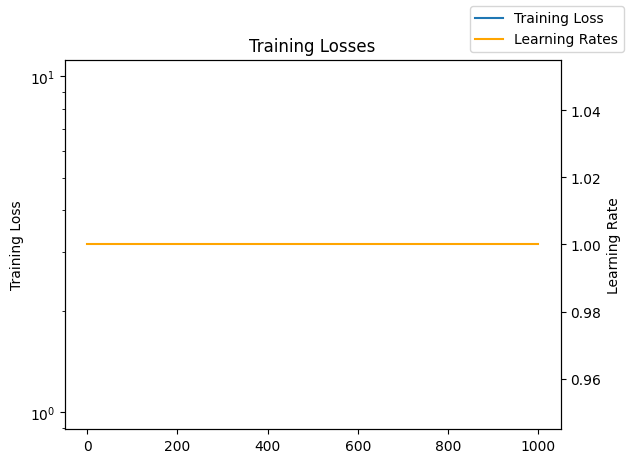

In [75]:
fig, ax = plt.subplots()
ax.plot(losses[5:], label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [76]:
# %%
with torch.no_grad(): 
    integrator.eval()
    output_states = integrator(initial_state, control_inputs)#, delta_times)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

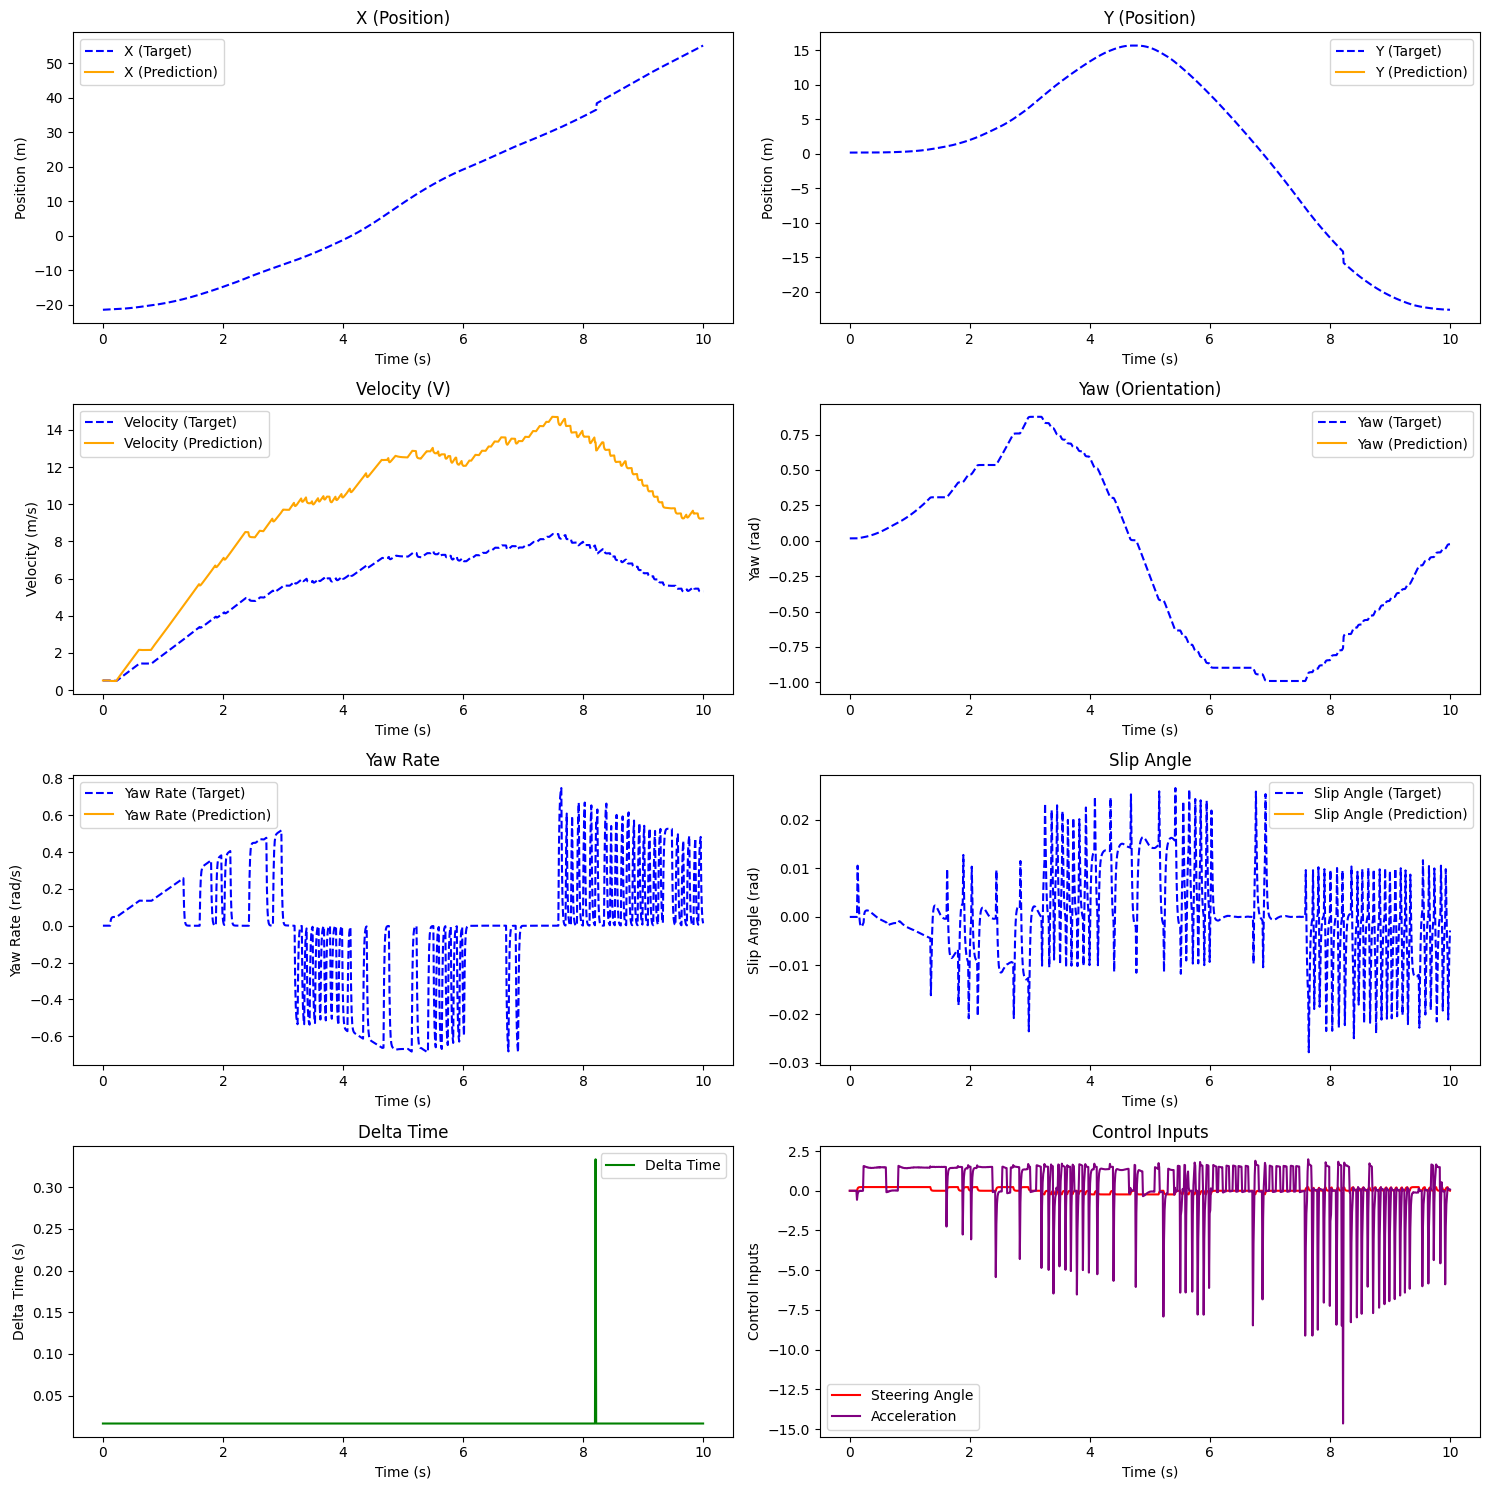

In [77]:
LEN = 1000  # Adjust the length of data you want to plot

# Extracting individual states from the output_states tensor (predictions)
x_pred = output_states[:LEN, 0].cpu().numpy()  # X position (prediction)
y_pred = output_states[:LEN, 1].cpu().numpy()  # Y position (prediction)
v_pred = output_states[:LEN, 2].cpu().numpy()  # Velocity (prediction)
yaw_pred = output_states[:LEN, 3].cpu().numpy()  # Yaw (prediction)
yaw_rate_pred = output_states[:LEN, 4].cpu().numpy()  # Yaw rate (prediction)
slip_angle_pred = output_states[:LEN, 5].cpu().numpy()  # Slip angle (prediction)

# Extracting individual states from the target_states tensor (ground truth)
x_target = target_states[:LEN, 0].cpu().numpy()  # X position (target)
y_target = target_states[:LEN, 1].cpu().numpy()  # Y position (target)
v_target = target_states[:LEN, 2].cpu().numpy()  # Velocity (target)
yaw_target = target_states[:LEN, 3].cpu().numpy()  # Yaw (target)
yaw_rate_target = target_states[:LEN, 4].cpu().numpy()  # Yaw rate (target)
slip_angle_target = target_states[:LEN, 5].cpu().numpy()  # Slip angle (target)

# Time or steps for x-axis
time = torch.linspace(0, 10, LEN).cpu().numpy()  # Example time array

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 15))

# Plot X and Y positions separately (Predicted vs Target)
axs[0, 0].plot(time, x_target, label='X (Target)', color='blue', linestyle='--')
axs[0, 0].plot(time, x_pred, label='X (Prediction)', color='orange')
axs[0, 0].set_title('X (Position)')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('Position (m)')
axs[0, 0].legend()

axs[0, 1].plot(time, y_target, label='Y (Target)', color='blue', linestyle='--')
axs[0, 1].plot(time, y_pred, label='Y (Prediction)', color='orange')
axs[0, 1].set_title('Y (Position)')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('Position (m)')
axs[0, 1].legend()

# Plot Velocity and Yaw (Predicted vs Target)
axs[1, 0].plot(time, v_target, label='Velocity (Target)', color='blue', linestyle='--')
axs[1, 0].plot(time, v_pred, label='Velocity (Prediction)', color='orange')
axs[1, 0].set_title('Velocity (V)')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Velocity (m/s)')
axs[1, 0].legend()

axs[1, 1].plot(time, yaw_target, label='Yaw (Target)', color='blue', linestyle='--')
axs[1, 1].plot(time, yaw_pred, label='Yaw (Prediction)', color='orange')
axs[1, 1].set_title('Yaw (Orientation)')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Yaw (rad)')
axs[1, 1].legend()

# Plot Yaw Rate and Slip Angle (Predicted vs Target)
axs[2, 0].plot(time, yaw_rate_target, label='Yaw Rate (Target)', color='blue', linestyle='--')
axs[2, 0].plot(time, yaw_rate_pred, label='Yaw Rate (Prediction)', color='orange')
axs[2, 0].set_title('Yaw Rate')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Yaw Rate (rad/s)')
axs[2, 0].legend()

axs[2, 1].plot(time, slip_angle_target, label='Slip Angle (Target)', color='blue', linestyle='--')
axs[2, 1].plot(time, slip_angle_pred, label='Slip Angle (Prediction)', color='orange')
axs[2, 1].set_title('Slip Angle')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Slip Angle (rad)')
axs[2, 1].legend()

# Plot delta time
axs[3, 0].plot(time, delta_times[:LEN], label='Delta Time', color='green')
axs[3, 0].set_title('Delta Time')
axs[3, 0].set_xlabel('Time (s)')
axs[3, 0].set_ylabel('Delta Time (s)')
axs[3, 0].legend()

# Plot acceleration and steering angle
axs[3, 1].plot(time, control_inputs[:LEN, 0], label='Steering Angle', color='red')
axs[3, 1].plot(time, control_inputs[:LEN, 1], label='Acceleration', color='purple')
axs[3, 1].set_title('Control Inputs')
axs[3, 1].set_xlabel('Time (s)')
axs[3, 1].set_ylabel('Control Inputs')
axs[3, 1].legend()


# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [78]:
print(target_states[0, 2])  

tensor(0.5167)


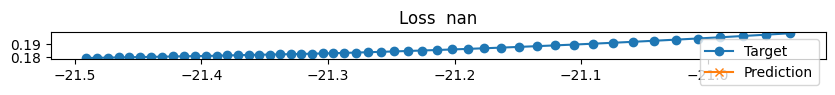

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=50
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target", marker='o')
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction", marker='x')
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [80]:
print("{")
for key in param_group.params.state_dict().keys():
    print(f"\t\"{key}\" : {param_group.params.state_dict()[key]},")
print("}")

{
	"l" : 2.5,
	"w" : 1.7999999523162842,
	"m" : -94879064.0,
	"Iz" : 71162384.0,
	"lf" : 0.75,
	"lr" : 1.75,
	"hcg" : 318347116544.0,
	"Csf" : -621604306944.0,
	"Csr" : -62756528128.0,
	"mu" : -762949206016.0,
}
